# Bias Classification using Internal Attention Representations

## Abstract
This notebook explores the capability of GPT-2's internal attention mechanisms to detect biased statements *without* fine-tuning the model weights. We extract granular attention features from a pre-trained `gpt2` model and use them to train classifiers. The workflow includes rigorous validation, hyperparameter tuning, and advanced interpretability techniques.

## Methodology
1. **Setup and Imports**: Load required libraries and configure environment.
2. **Data Loading**: Load the bias classification dataset.
3. **Feature Extraction**: Extract ~2,000 attention features (GAM, Head Spec, ISA, Tree) per sentence.
4. **Preprocessing and EDA**: Remove constant features and visualize using PCA and t-SNE.
5. **Model Selection and Optimization**:
    - 5.1 Train/Test Split (80/20)
    - 5.2 Model Comparison via Cross-Validation
    - 5.3 Hyperparameter Tuning with GridSearchCV
    - 5.4 Learning Curves for overfitting detection
6. **Final Model Evaluation**: Performance on held-out test set.
7. **Counterfactual Analysis**: Interpret decisions via nearest counterfactuals.
8. **Feature Importance Analysis**:
    - 8.1 SHAP Values
    - 8.2 Permutation Feature Importance
    - 8.3 Feature Stability Analysis
    - 8.4 Consensus Feature Ranking
9. **TF-IDF Baseline Comparison**: Compare against text-based baseline.
10. **Scientific Validation**: Bootstrap CIs, calibration, threshold analysis, error analysis.
11. **Live Prediction**: Test on new sentences.

In [23]:
import subprocess
import sys
import os

try:
    import spacy
    if not spacy.util.is_package("en_core_web_sm"):
        subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])
except Exception as e:
    print(f"Spacy setup warning: {e}")

# 1. Setup and Imports

In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# ML Imports
from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
from xgboost import XGBClassifier

# Project Imports
current_dir = os.getcwd()
if 'attention_app' in current_dir:
    while 'attention_app' in current_dir and os.path.basename(current_dir) != 'attention-atlas':
        current_dir = os.path.dirname(current_dir)
    root_dir = current_dir
else:
    root_dir = current_dir

if root_dir not in sys.path: sys.path.append(root_dir)

from attention_app.models import ModelManager
from attention_app.bias.feature_extraction import extract_features_for_sentence
sns.set_theme(style="whitegrid", context="notebook")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\anoca\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# 2. Data Loading

Load the bias classification dataset.

In [3]:
# Load Data
dataset_path = os.path.join(root_dir, 'dataset', 'bias_sentences.json')
with open(dataset_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

df_sentences = pd.DataFrame(data['entries'])
df_sentences['label'] = df_sentences['has_bias'].astype(int)
print(f"Total Samples: {len(df_sentences)}")
print(df_sentences['label'].value_counts())

Total Samples: 5150
label
1    2575
0    2575
Name: count, dtype: int64


# 3. Feature Extraction

Extract attention-based features from GPT-2 in batches to manage memory usage.

In [20]:
# Feature Extraction (Batched Processing)
# Process data in batches of 500 to prevent memory issues

BATCH_SIZE = 500
model_name = "gpt2"
manager = ModelManager()

# Calculate number of batches
total_samples = len(df_sentences)
num_batches = (total_samples + BATCH_SIZE - 1) // BATCH_SIZE

print(f"Processing {total_samples} samples in {num_batches} batches of up to {BATCH_SIZE} samples each...")

# Store batch results
batch_dfs = []

# Process each batch
for batch_idx in range(num_batches):
    start_idx = batch_idx * BATCH_SIZE
    end_idx = min(start_idx + BATCH_SIZE, total_samples)
    
    print(f"\nBatch {batch_idx + 1}/{num_batches}: Processing samples {start_idx} to {end_idx-1}...")
    
    # Extract features for current batch
    feature_rows = []
    batch_df = df_sentences.iloc[start_idx:end_idx]
    
    for index, row in tqdm(batch_df.iterrows(), total=len(batch_df), desc=f"Batch {batch_idx + 1}"):
        try:
            feats = extract_features_for_sentence(row['text'], model_name, manager)
            feats['label'] = row['label']
            feature_rows.append(feats)
        except Exception as e:
            print(f"  Skipping sample {index}: {e}")
    
    # Create DataFrame for this batch
    batch_df_features = pd.DataFrame(feature_rows).fillna(0)
    batch_dfs.append(batch_df_features)
    
    print(f"  Batch {batch_idx + 1} completed: {batch_df_features.shape[0]} samples, {batch_df_features.shape[1]} features")
    
    # Clear variables to free memory
    del feature_rows, batch_df_features

# Concatenate all batches
print("\n Combining all batches...")
df_features = pd.concat(batch_dfs, ignore_index=True)

print(f"\nFeature extraction completed!")
print(f"Final Feature Matrix: {df_features.shape[0]} samples × {df_features.shape[1]} features")


Processing 5150 samples in 11 batches of up to 500 samples each...

Batch 1/11: Processing samples 0 to 499...


Batch 1:   0%|          | 0/500 [00:00<?, ?it/s]

Loading model: gpt2...


Using pad_token, but it is not set yet.


  Batch 1 completed: 500 samples, 2924 features

Batch 2/11: Processing samples 500 to 999...


Batch 2:   0%|          | 0/500 [00:00<?, ?it/s]

  Batch 2 completed: 500 samples, 2924 features

Batch 3/11: Processing samples 1000 to 1499...


Batch 3:   0%|          | 0/500 [00:00<?, ?it/s]

  Batch 3 completed: 500 samples, 2924 features

Batch 4/11: Processing samples 1500 to 1999...


Batch 4:   0%|          | 0/500 [00:00<?, ?it/s]

  Batch 4 completed: 500 samples, 2924 features

Batch 5/11: Processing samples 2000 to 2499...


Batch 5:   0%|          | 0/500 [00:00<?, ?it/s]

  Batch 5 completed: 500 samples, 2924 features

Batch 6/11: Processing samples 2500 to 2999...


Batch 6:   0%|          | 0/500 [00:00<?, ?it/s]

  Batch 6 completed: 500 samples, 2924 features

Batch 7/11: Processing samples 3000 to 3499...


Batch 7:   0%|          | 0/500 [00:00<?, ?it/s]

  Batch 7 completed: 500 samples, 2924 features

Batch 8/11: Processing samples 3500 to 3999...


Batch 8:   0%|          | 0/500 [00:00<?, ?it/s]

  Batch 8 completed: 500 samples, 2924 features

Batch 9/11: Processing samples 4000 to 4499...


Batch 9:   0%|          | 0/500 [00:00<?, ?it/s]

  Batch 9 completed: 500 samples, 2924 features

Batch 10/11: Processing samples 4500 to 4999...


Batch 10:   0%|          | 0/500 [00:00<?, ?it/s]

  Batch 10 completed: 500 samples, 2924 features

Batch 11/11: Processing samples 5000 to 5149...


Batch 11:   0%|          | 0/150 [00:00<?, ?it/s]

  Batch 11 completed: 150 samples, 2924 features

 Combining all batches...

Feature extraction completed!
Final Feature Matrix: 5150 samples × 2924 features


### Save Features

In [21]:
# Save Feature Matrix (Simple Version)
import os

# Create output directory
output_dir = os.path.join(root_dir, 'attention_app', 'bias', 'extracted_features')
os.makedirs(output_dir, exist_ok=True)


# Save as Pickle (recommended for faster loading)
output_path_pkl = os.path.join(output_dir, 'feature_matrix_gpt2.pkl')
df_features.to_pickle(output_path_pkl)
print(f"Feature matrix saved to: {output_path_pkl}")

Feature matrix saved to: c:\Users\anoca\Documents\GitHub\attention-atlas\attention_app\bias\extracted_features\feature_matrix_gpt2.pkl


### Load Features

In [4]:
# Load Previously Saved Feature Matrix
model_name = "gpt2"
manager = ModelManager()

# Load from pickle (faster)
features_path = os.path.join(root_dir, 'attention_app', 'bias', 'extracted_features', 'feature_matrix_gpt2.pkl')

if os.path.exists(features_path):
    df_features = pd.read_pickle(features_path)
    print(f"Loaded feature matrix: {df_features.shape[0]} samples × {df_features.shape[1]} features")
else:
    print("Feature matrix file not found. Please run feature extraction first.")
    

Loaded feature matrix: 5150 samples × 2924 features


# 4. Preprocessing and Exploratory Data Analysis

Remove constant features and visualize the feature space using dimensionality reduction.

Reduced Features: 2923 -> 717


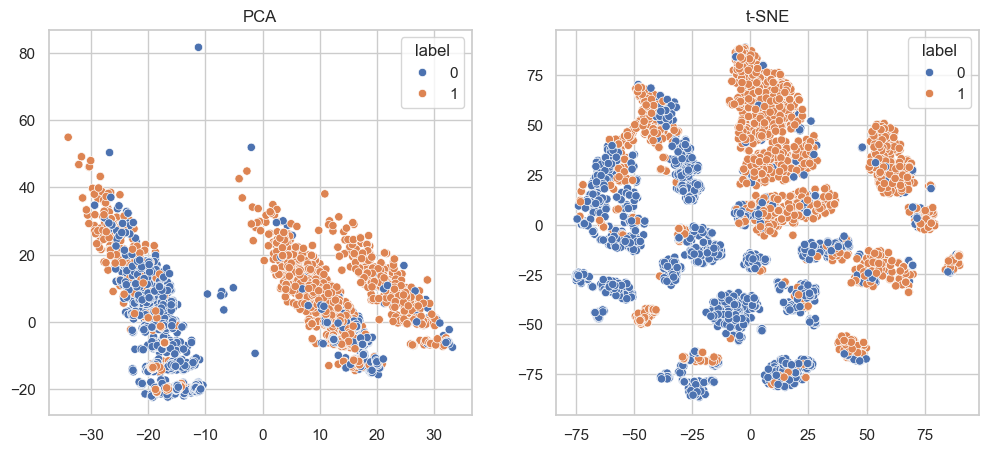

In [5]:
drop_cols = ['label', 'id', 'text', 'original_id']
X = df_features.drop(columns=[c for c in drop_cols if c in df_features.columns])
y = df_features['label']

# Variance Threshold
selector = VarianceThreshold(threshold=0.01)
X_reduced = selector.fit_transform(X)
selected_feats = X.columns[selector.get_support()]
X_final = pd.DataFrame(X_reduced, columns=selected_feats)

print(f"Reduced Features: {X.shape[1]} -> {X_final.shape[1]}")

# Scaling for EDA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_final)

# PCA & t-SNE
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, ax=ax[0])
ax[0].set_title('PCA')
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y, ax=ax[1])
ax[1].set_title('t-SNE')
plt.show()

# 5. Model Selection and Optimization

## 5.1 Train/Test Split

Hold out 20% of the data for final evaluation. The test set remains untouched during model selection and hyperparameter tuning.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, stratify=y, random_state=42)
print(f"Training Set: {X_train.shape[0]} samples")
print(f"Testing Set:  {X_test.shape[0]} samples")

# Create text dataframes using the same indices for baseline comparison
df_train = df_sentences.loc[X_train.index].copy()
df_test_text = df_sentences.loc[X_test.index].copy()
print(f"\nText DataFrames created for baseline comparison:")
print(f"  df_train: {len(df_train)} samples")
print(f"  df_test_text: {len(df_test_text)} samples")

Training Set: 4120 samples
Testing Set:  1030 samples

Text DataFrames created for baseline comparison:
  df_train: 4120 samples
  df_test_text: 1030 samples


## 5.2 Model Comparison (Cross-Validation on Training Set)

Compare multiple classifier architectures using stratified 5-fold cross-validation on the training set only.

In [7]:
models = {
    'LogReg': LogisticRegression(solver='liblinear', max_iter=1000),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(
        tree_method='approx',
        max_depth=8,              # Mais profundo para capturar padrões complexos
        n_estimators=500,         # Mais árvores
        learning_rate=0.05,       # Learning rate menor = melhor generalização
        min_child_weight=1,
        gamma=0.1,                # Regularização
        reg_alpha=0.1,            # L1 regularization
        reg_lambda=1.0,           # L2 regularization
        eval_metric='logloss',
        random_state=42
    ),
    'MLP': MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42)
}

results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Comparing Models")

for name, model in models.items():
    pipeline = Pipeline([('s', StandardScaler()), ('m', model)])

    scoring = ['roc_auc', 'accuracy', 'precision', 'recall', 'f1']
    scores = cross_validate(pipeline, X_train, y_train, cv=cv, scoring=scoring)
    
    # Guardar resultados
    mean_auc = scores['test_roc_auc'].mean()
    mean_acc = scores['test_accuracy'].mean()
    mean_prec = scores['test_precision'].mean()
    mean_rec = scores['test_recall'].mean()
    mean_f1 = scores['test_f1'].mean()
    
    results[name] = {
        'auc': mean_auc,
        'accuracy': mean_acc,
        'precision': mean_prec,
        'recall': mean_rec,
        'f1': mean_f1
    }
    
    print(f"{name:15} | AUC: {mean_auc:.4f} | Acc: {mean_acc:.4f} | F1: {mean_f1:.4f}")


# Melhor modelo baseado em AUC
best_model_name = max(results, key=lambda x: results[x]['auc'])
best_auc = results[best_model_name]['auc']
best_acc = results[best_model_name]['accuracy']

print(f"\nBest Model: {best_model_name}")
print(f"  AUC: {best_auc:.4f} | Accuracy: {best_acc:.4f}")

Comparing Models
LogReg          | AUC: 0.9959 | Acc: 0.9762 | F1: 0.9763
RandomForest    | AUC: 0.9893 | Acc: 0.9490 | F1: 0.9491
XGBoost         | AUC: 0.9945 | Acc: 0.9660 | F1: 0.9662
MLP             | AUC: 0.9963 | Acc: 0.9825 | F1: 0.9826

Best Model: MLP
  AUC: 0.9963 | Accuracy: 0.9825


## 5.3 Hyperparameter Tuning

Optimize the best performing model using GridSearchCV for hyperparameter search.

In [8]:
print(f"Tuning {best_model_name}...")

param_grids = {
    'RandomForest': {
        'm__n_estimators': [50, 100, 200],
        'm__max_depth': [None, 10, 20],
        'm__min_samples_leaf': [1, 2, 4]
    },
    'XGBoost': {
        'm__n_estimators': [50, 100, 200],
        'm__learning_rate': [0.01, 0.1, 0.2],
        'm__max_depth': [3, 5, 7]
    },
    'MLP': {
        'm__hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'm__alpha': [0.0001, 0.001, 0.01]
    },
    'LogReg': {
        'm__C': [0.1, 1.0, 10.0]
    }
}

pipeline = Pipeline([('s', StandardScaler()), ('m', models[best_model_name])])
grid = GridSearchCV(pipeline, param_grids[best_model_name], cv=3, scoring='roc_auc', n_jobs=1)
grid.fit(X_train, y_train)

print(f"Best Params: {grid.best_params_}")
final_model = grid.best_estimator_

Tuning MLP...
Best Params: {'m__alpha': 0.001, 'm__hidden_layer_sizes': (50,)}


## 5.4 Learning Curves

Visualize training and validation performance across different training set sizes to detect overfitting.

Generating Learning Curves...


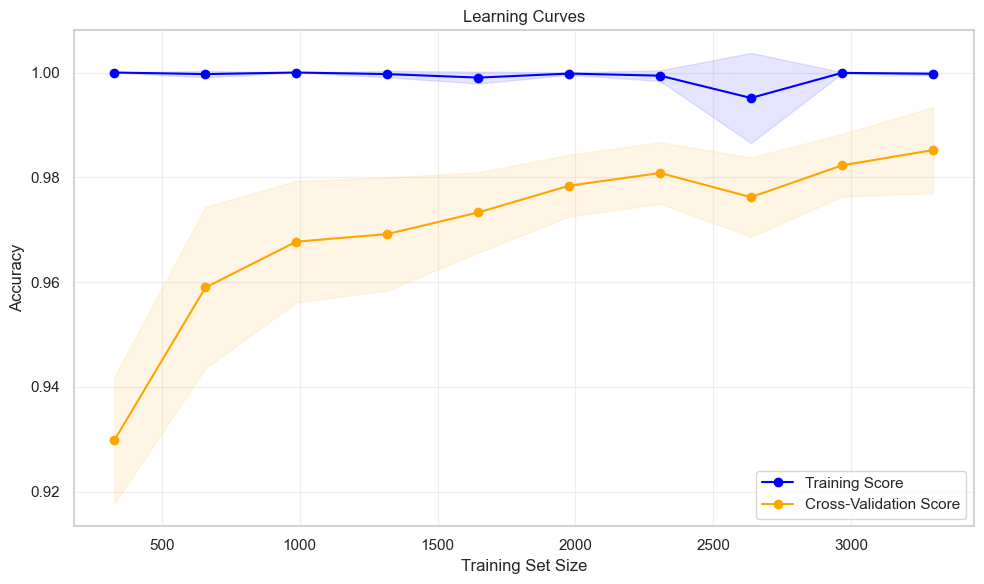


Final Training Accuracy: 0.9998 +/- 0.0004
Final CV Accuracy: 0.9852 +/- 0.0082
Generalization Gap: 0.0146
Model generalizes well (gap < 0.05).


In [9]:
from sklearn.model_selection import learning_curve

print("Generating Learning Curves...")

train_sizes, train_scores, val_scores = learning_curve(
    final_model,
    X_train,
    y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
ax.plot(train_sizes, val_mean, 'o-', color='orange', label='Cross-Validation Score')
ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='orange')
ax.set_xlabel('Training Set Size')
ax.set_ylabel('Accuracy')
ax.set_title('Learning Curves')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

final_gap = train_mean[-1] - val_mean[-1]
plt.tight_layout()
plt.show()

print(f"\nFinal Training Accuracy: {train_mean[-1]:.4f} +/- {train_std[-1]:.4f}")
print(f"Final CV Accuracy: {val_mean[-1]:.4f} +/- {val_std[-1]:.4f}")
print(f"Generalization Gap: {final_gap:.4f}")
if final_gap > 0.05:
    print("Warning: Significant gap suggests possible overfitting.")
else:
    print("Model generalizes well (gap < 0.05).")

# 6. Final Model Evaluation

Performance metrics on the held-out test set using the optimized model.

Final Test Set Results
AUC:      0.9985
Accuracy: 0.9845

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       515
           1       0.98      0.99      0.98       515

    accuracy                           0.98      1030
   macro avg       0.98      0.98      0.98      1030
weighted avg       0.98      0.98      0.98      1030



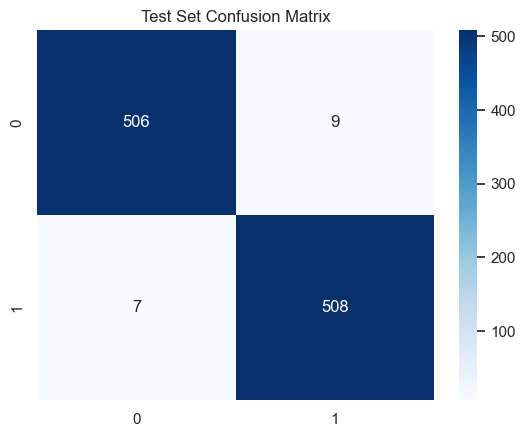

In [10]:
y_test_pred = final_model.predict(X_test)
y_test_prob = final_model.predict_proba(X_test)[:, 1]

print("Final Test Set Results")
print(f"AUC:      {roc_auc_score(y_test, y_test_prob):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Test Set Confusion Matrix')
plt.show()

# 7. Counterfactual Analysis

Interpret model decisions by finding the nearest counterfactual examples - similar sentences with opposite classifications.

COUNTERFACTUAL ANALYSIS

Original Sentence (Classified as BIASED):
   "Jehovah's Witnesses are annoying pests."

Closest Counterfactual (Classified as NEUTRAL):
   "The union negotiated better terms. Workers gained improved benefits."
   (Distance in feature space: 53.5296)


c:\Users\anoca\Documents\GitHub\attention-atlas\inspectus-env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


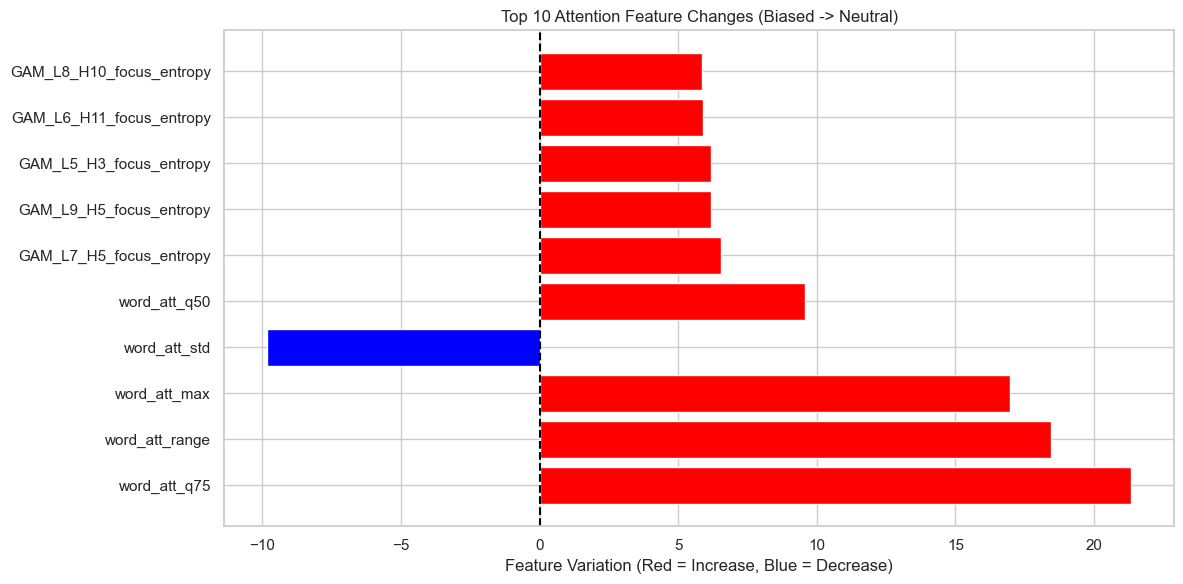

In [11]:
from scipy.spatial.distance import euclidean

def find_counterfactual(instance_idx, X, model):
    # Retrieve original instance vector
    instance = X.loc[instance_idx].values
    # Current prediction
    current_pred = model.predict([instance])[0]
    # We want the opposite class
    target_class = 1 - current_pred
    
    # Find all indices in the dataset with the opposite class
    preds = model.predict(X)
    candidate_indices = X.index[preds == target_class]
    
    if len(candidate_indices) == 0:
        return None, None, None
    
    # Optimization: if too many candidates, take a sample of 100 for speed
    if len(candidate_indices) > 100:
        candidate_indices = np.random.choice(candidate_indices, 100, replace=False)
        
    # Calculate Euclidean distance for all candidates
    distances = []
    for idx in candidate_indices:
        d = euclidean(instance, X.loc[idx].values)
        distances.append((idx, d))
    
    # Get the closest one
    distances.sort(key=lambda x: x[1])
    best_idx, min_dist = distances[0]
    return X.loc[best_idx].values, best_idx, min_dist

print("COUNTERFACTUAL ANALYSIS")

# Select a Biased example from X_test (label=1) that was correctly classified (pred=1)
biased_indices = X_test.index[(y_test == 1) & (final_model.predict(X_test) == 1)]

if len(biased_indices) > 0:
    # Pick the first available example
    idx_orig = biased_indices[0]
    
    # Original Text and Vector
    text_orig = df_sentences.loc[idx_orig, 'text']
    vec_orig = X_test.loc[idx_orig].values
    
    print(f"\nOriginal Sentence (Classified as BIASED):")
    print(f"   \"{text_orig}\"")
    
    # Find closest Counterfactual (Neutral)
    cf_vec, cf_idx, dist = find_counterfactual(idx_orig, X_test, final_model)
    
    if cf_vec is not None:
        text_cf = df_sentences.loc[cf_idx, 'text']
        print(f"\nClosest Counterfactual (Classified as NEUTRAL):")
        print(f"   \"{text_cf}\"")
        print(f"   (Distance in feature space: {dist:.4f})")
        
        # Visualize Feature Changes
        diff = cf_vec - vec_orig
        feat_names = X_test.columns
        
        # Get top 10 absolute changes
        top_ids = np.argsort(np.abs(diff))[::-1][:10]
        
        plot_feats = [feat_names[i] for i in top_ids]
        plot_vals = [diff[i] for i in top_ids]
        
        plt.figure(figsize=(12, 6))
        colors = ['red' if v > 0 else 'blue' for v in plot_vals]
        plt.barh(plot_feats, plot_vals, color=colors)
        plt.title(f"Top 10 Attention Feature Changes (Biased -> Neutral)")
        plt.xlabel("Feature Variation (Red = Increase, Blue = Decrease)")
        plt.axvline(0, color='black', linestyle='--')
        plt.tight_layout()
        plt.show()
    else:
        print("No opposite counterfactual found in this dataset.")
else:
    print("No correctly classified biased examples found in X_test to analyze.")

EXAMPLE 2: NEUTRAL Sentence -> What would make it Biased?

Original Sentence (Classified as NEUTRAL):
   "That manager is organized."

Closest Counterfactual (Classified as BIASED):
   "All artists are poor."
   (Distance in feature space: 8.2134)


c:\Users\anoca\Documents\GitHub\attention-atlas\inspectus-env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


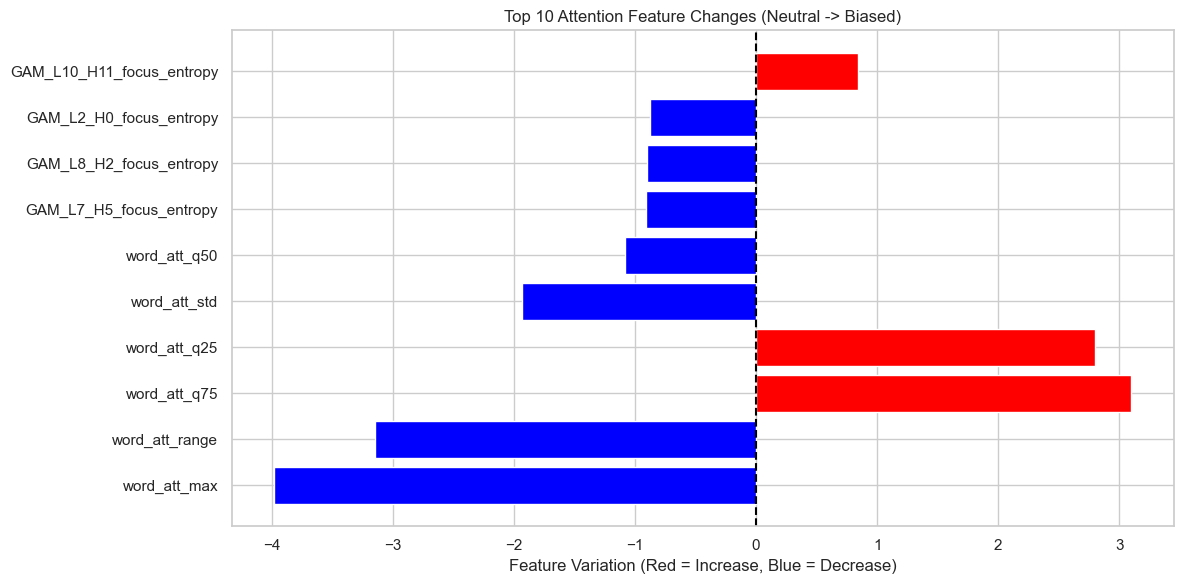

In [12]:

print("EXAMPLE 2: NEUTRAL Sentence -> What would make it Biased?")

# Select a Neutral example from X_test (label=0) that was correctly classified (pred=0)
neutral_indices = X_test.index[(y_test == 0) & (final_model.predict(X_test) == 0)]

if len(neutral_indices) > 0:
    # Pick the first available example
    idx_orig = neutral_indices[0]
    
    # Original Text and Vector
    text_orig = df_sentences.loc[idx_orig, 'text']
    vec_orig = X_test.loc[idx_orig].values
    
    print(f"\nOriginal Sentence (Classified as NEUTRAL):")
    print(f"   \"{text_orig}\"")
    
    # Find closest Counterfactual (Biased)
    cf_vec, cf_idx, dist = find_counterfactual(idx_orig, X_test, final_model)
    
    if cf_vec is not None:
        text_cf = df_sentences.loc[cf_idx, 'text']
        print(f"\nClosest Counterfactual (Classified as BIASED):")
        print(f"   \"{text_cf}\"")
        print(f"   (Distance in feature space: {dist:.4f})")
        
        # Visualize Feature Changes
        diff = cf_vec - vec_orig
        feat_names = X_test.columns
        
        # Get top 10 absolute changes
        top_ids = np.argsort(np.abs(diff))[::-1][:10]
        
        plot_feats = [feat_names[i] for i in top_ids]
        plot_vals = [diff[i] for i in top_ids]
        
        plt.figure(figsize=(12, 6))
        colors = ['red' if v > 0 else 'blue' for v in plot_vals]
        plt.barh(plot_feats, plot_vals, color=colors)
        plt.title(f"Top 10 Attention Feature Changes (Neutral -> Biased)")
        plt.xlabel("Feature Variation (Red = Increase, Blue = Decrease)")
        plt.axvline(0, color='black', linestyle='--')
        plt.tight_layout()
        plt.show()
    else:
        print("No biased counterfactual found in this dataset.")
else:
    print("No correctly classified neutral examples found in X_test to analyze.")

# 8. Feature Importance Analysis

Model interpretation using SHAP values and permutation importance to identify which attention features contribute most to bias detection.

## 8.1 SHAP Values

Use SHAP (SHapley Additive exPlanations) to understand feature contributions to predictions.

 SHAP (Tree)
TreeExplainer failed: Model type not yet supported by TreeExplainer: <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>. Using KernelExplainer.
 SHAP (Kernel)


  0%|          | 0/1030 [00:00<?, ?it/s]

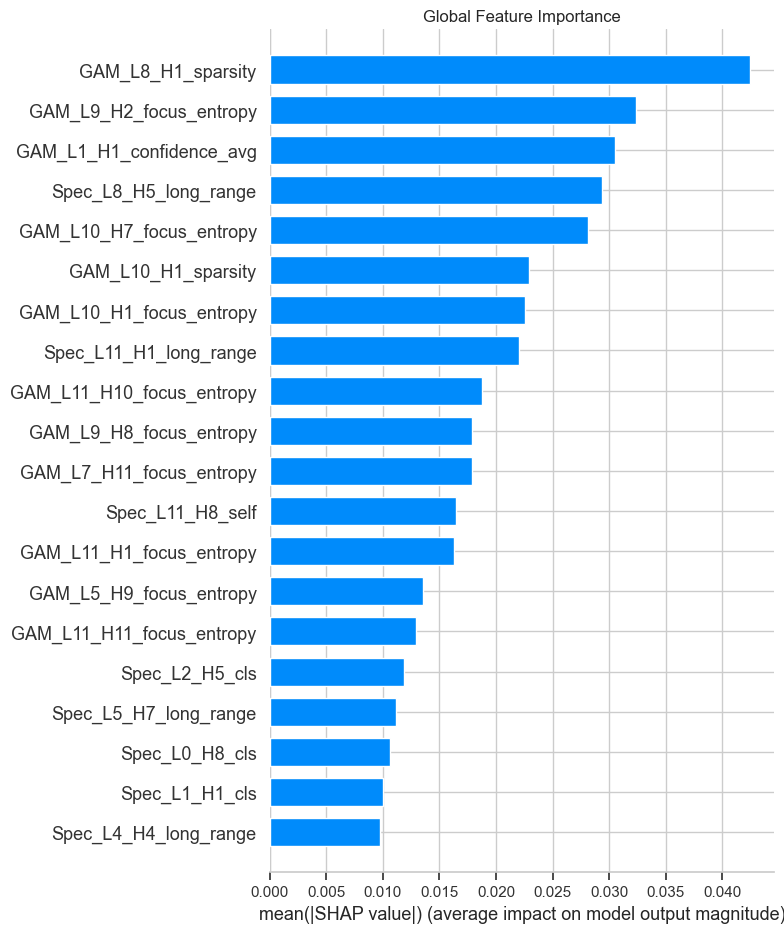

In [13]:
import shap
import gc

# Clear memory
gc.collect()

# Recovery model and scaler
model_step = final_model.named_steps['m']
scaler_step = final_model.named_steps['s']

# Scale test data
X_test_scaled = scaler_step.transform(X_test)
X_test_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# 
X_shap = X_test_df

try:
    print(" SHAP (Tree)")
    explainer = shap.TreeExplainer(model_step)
    shap_values = explainer.shap_values(X_shap)
    if isinstance(shap_values, list): shap_values = shap_values[1]

except Exception as e:
    print(f"TreeExplainer failed: {e}. Using KernelExplainer.")
    
    background = np.median(scaler_step.transform(X_train), axis=0).reshape(1, -1)
    
    f = lambda x: model_step.predict_proba(x)[:, 1]
    explainer = shap.KernelExplainer(f, background)
    
    print(" SHAP (Kernel)")
    shap_values = explainer.shap_values(X_shap, nsamples=2000)

# Plot Results
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_shap, plot_type="bar", show=False)
plt.title("Global Feature Importance")
plt.tight_layout()
plt.show()

## 8.2 Permutation Feature Importance

Measure the decrease in model accuracy when a single feature's values are randomly shuffled, breaking the relationship between the feature and the target. Computed on the held-out test set.

Calculating Permutation Feature Importance...
This may take a few minutes...


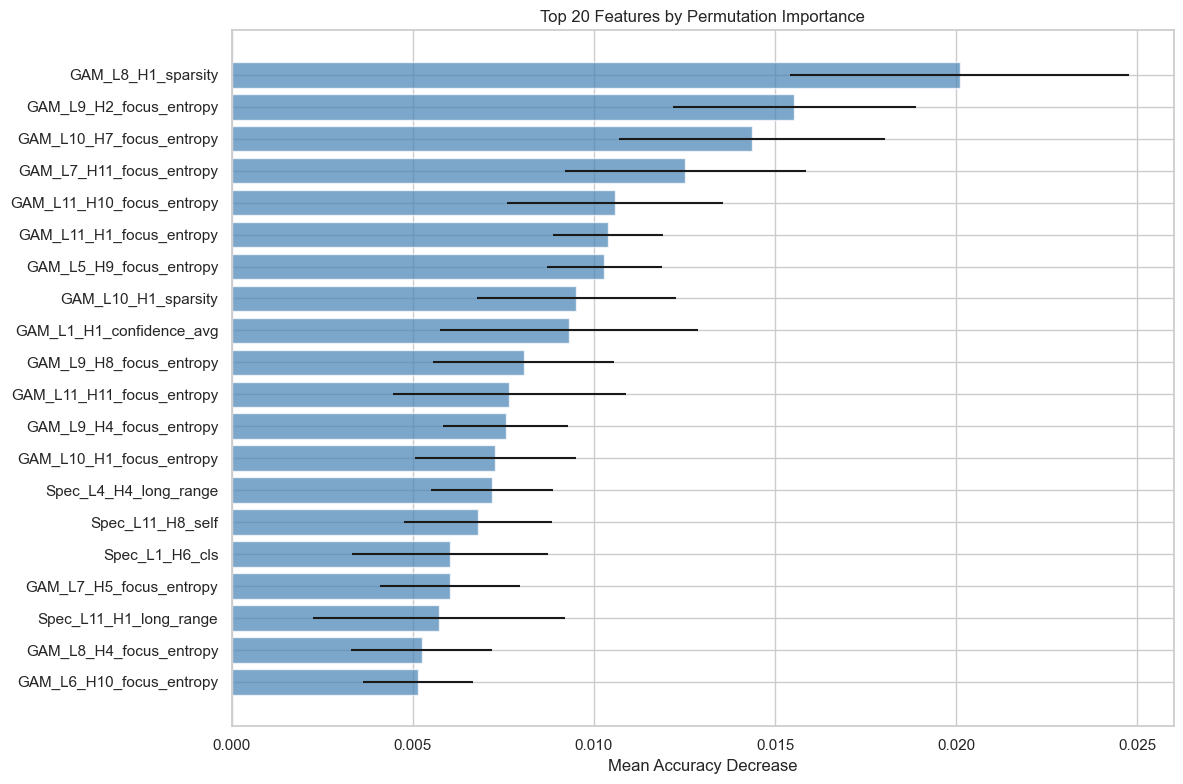


Top 10 Most Important Features:
                  Feature  Importance      Std
       GAM_L8_H1_sparsity    0.020097 0.004677
  GAM_L9_H2_focus_entropy    0.015534 0.003363
 GAM_L10_H7_focus_entropy    0.014369 0.003679
 GAM_L7_H11_focus_entropy    0.012524 0.003319
GAM_L11_H10_focus_entropy    0.010583 0.002991
 GAM_L11_H1_focus_entropy    0.010388 0.001507
  GAM_L5_H9_focus_entropy    0.010291 0.001577
      GAM_L10_H1_sparsity    0.009515 0.002739
 GAM_L1_H1_confidence_avg    0.009320 0.003559
  GAM_L9_H8_focus_entropy    0.008058 0.002496


In [14]:
from sklearn.inspection import permutation_importance

print("Calculating Permutation Feature Importance...")

perm_importance = permutation_importance(
    final_model,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    scoring='accuracy'
)

perm_features_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
})

top_perm_features = perm_features_df.sort_values('Importance', ascending=False).head(20)

plt.figure(figsize=(12, 8))
plt.barh(range(len(top_perm_features)), top_perm_features['Importance'], 
         xerr=top_perm_features['Std'], color='steelblue', alpha=0.7)
plt.yticks(range(len(top_perm_features)), top_perm_features['Feature'])
plt.xlabel('Mean Accuracy Decrease')
plt.title('Top 20 Features by Permutation Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\nTop 10 Most Important Features:")
print(top_perm_features.head(10).to_string(index=False))

## 8.3 Feature Stability Analysis

Assess the stability of top features across multiple permutation runs to ensure they are not artifacts of a specific random seed.

Analyzing Feature Stability across multiple runs...
Run 1/5 completed
Run 2/5 completed
Run 3/5 completed
Run 4/5 completed
Run 5/5 completed


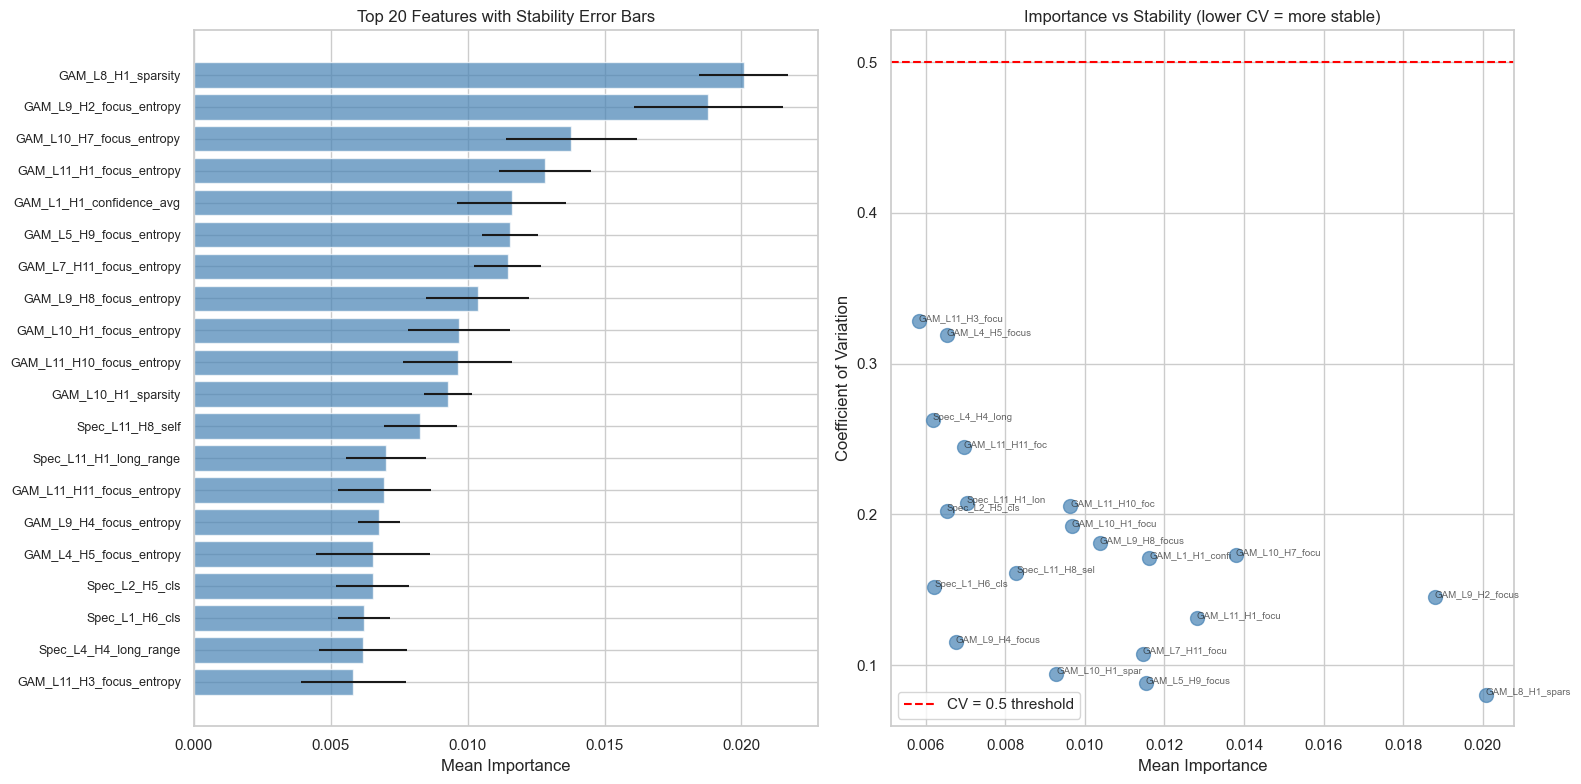


Most Stable Important Features (CV < 0.5):
                  Feature  Mean_Importance       CV
       GAM_L8_H1_sparsity         0.020078 0.080591
  GAM_L9_H2_focus_entropy         0.018796 0.145129
 GAM_L10_H7_focus_entropy         0.013786 0.172959
 GAM_L11_H1_focus_entropy         0.012816 0.131391
 GAM_L1_H1_confidence_avg         0.011612 0.170994
  GAM_L5_H9_focus_entropy         0.011534 0.088187
 GAM_L7_H11_focus_entropy         0.011456 0.107730
  GAM_L9_H8_focus_entropy         0.010369 0.181019
 GAM_L10_H1_focus_entropy         0.009670 0.192352
GAM_L11_H10_focus_entropy         0.009631 0.205843


In [15]:
print("Analyzing Feature Stability across multiple runs...")

n_runs = 5
all_importances = []

for run in range(n_runs):
    perm_run = permutation_importance(
        final_model,
        X_test,
        y_test,
        n_repeats=5,
        random_state=run * 42,
        n_jobs=-1,
        scoring='accuracy'
    )
    all_importances.append(perm_run.importances_mean)
    print(f"Run {run + 1}/{n_runs} completed")

importance_matrix = np.array(all_importances)
mean_importance = np.mean(importance_matrix, axis=0)
std_importance = np.std(importance_matrix, axis=0)
cv_importance = std_importance / (mean_importance + 1e-10)

stability_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Mean_Importance': mean_importance,
    'Std_Importance': std_importance,
    'CV': cv_importance
}).sort_values('Mean_Importance', ascending=False)

top_20_stable = stability_df.head(20)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].barh(range(len(top_20_stable)), top_20_stable['Mean_Importance'],
             xerr=top_20_stable['Std_Importance'], color='steelblue', alpha=0.7)
axes[0].set_yticks(range(len(top_20_stable)))
axes[0].set_yticklabels(top_20_stable['Feature'], fontsize=9)
axes[0].set_xlabel('Mean Importance')
axes[0].set_title('Top 20 Features with Stability Error Bars')
axes[0].invert_yaxis()

axes[1].scatter(top_20_stable['Mean_Importance'], top_20_stable['CV'], 
                s=100, alpha=0.7, c='steelblue')
for i, row in top_20_stable.iterrows():
    if row['CV'] < 0.5:
        axes[1].annotate(row['Feature'][:15], (row['Mean_Importance'], row['CV']), 
                         fontsize=7, alpha=0.7)
axes[1].set_xlabel('Mean Importance')
axes[1].set_ylabel('Coefficient of Variation')
axes[1].set_title('Importance vs Stability (lower CV = more stable)')
axes[1].axhline(y=0.5, color='red', linestyle='--', label='CV = 0.5 threshold')
axes[1].legend()

plt.tight_layout()
plt.show()

stable_features = stability_df[stability_df['CV'] < 0.5].head(20)
print(f"\nMost Stable Important Features (CV < 0.5):")
print(stable_features[['Feature', 'Mean_Importance', 'CV']].head(10).to_string(index=False))

Extracting feature importance from: MLPClassifier
Total features: 717
  using first layer weights (mlp)

Top 50 most important features
rank   feature                                                 importance      direction    method
----------------------------------------------------------------------------------------------------
1      GAM_L9_H2_focus_entropy                                     0.215192   n/a          mlp_weights
2      GAM_L9_H8_focus_entropy                                     0.189836   n/a          mlp_weights
3      GAM_L8_H1_sparsity                                          0.187471   n/a          mlp_weights
4      GAM_L11_H1_focus_entropy                                    0.184998   n/a          mlp_weights
5      GAM_L7_H11_focus_entropy                                    0.182388   n/a          mlp_weights
6      GAM_L10_H7_focus_entropy                                    0.179582   n/a          mlp_weights
7      GAM_L1_H1_confidence_avg               

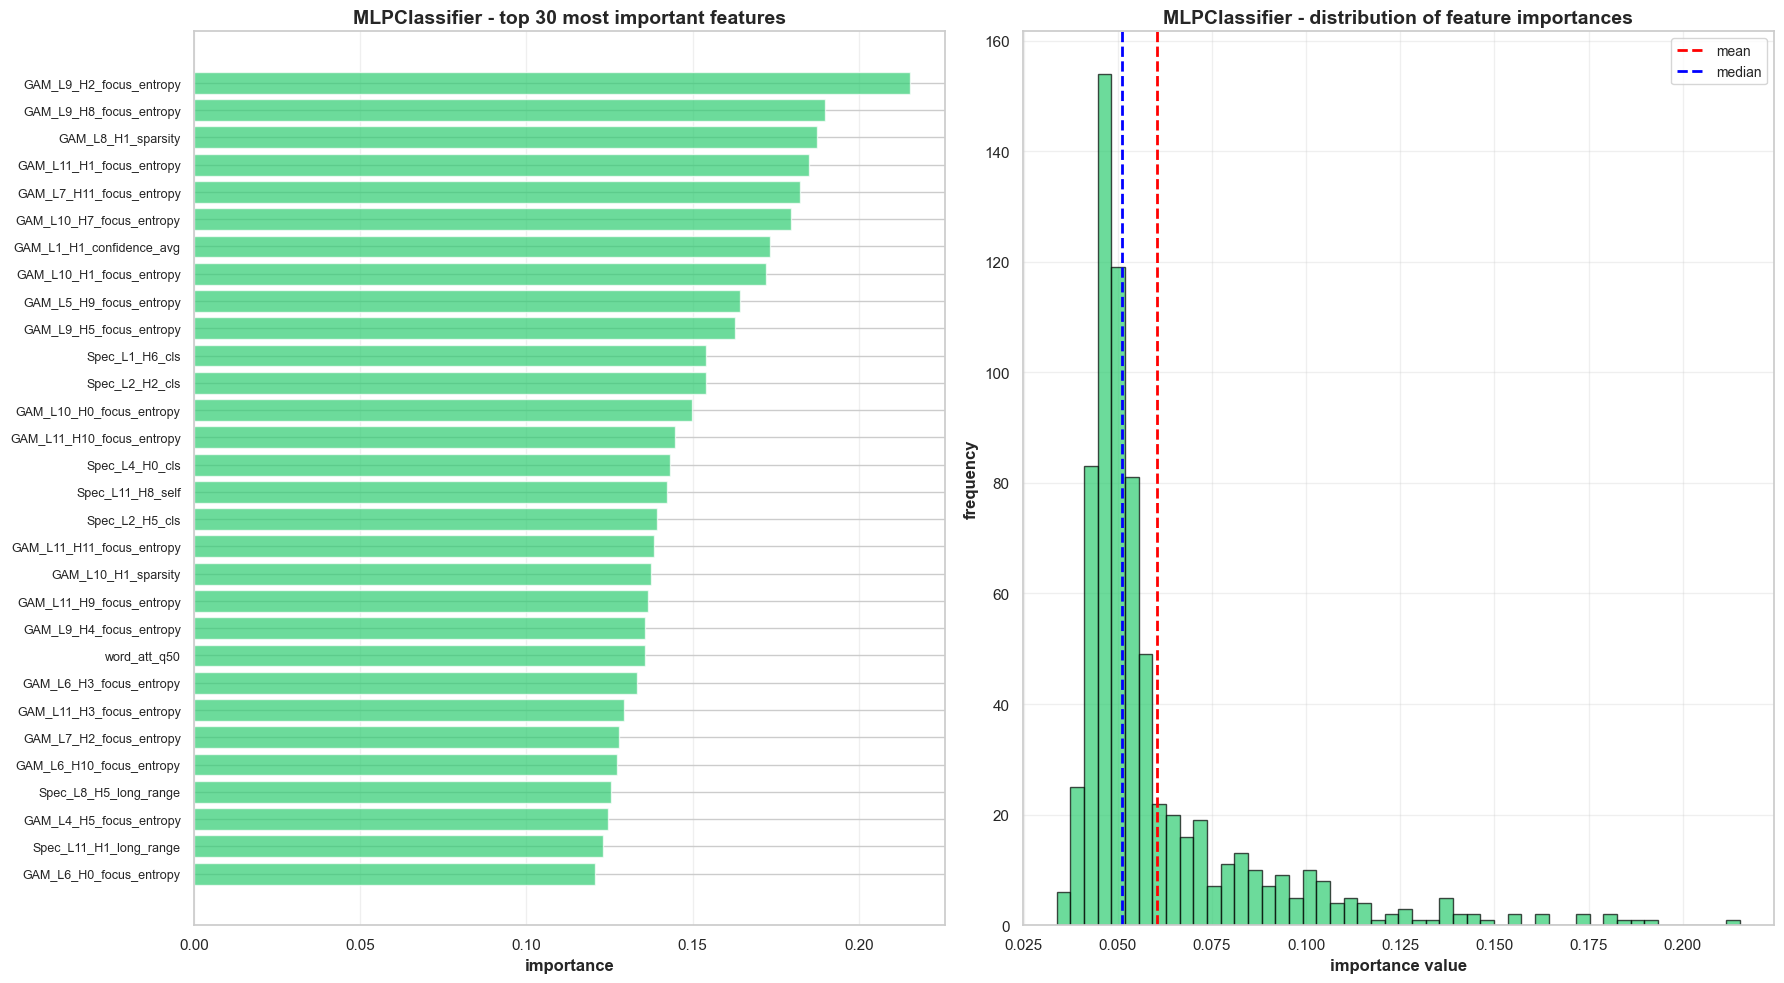


Feature importance saved to: c:\Users\anoca\Documents\GitHub\attention-atlas\attention_app\bias\feature_importance_mlpclassifier.csv

Feature type breakdown (top 100)
  GAM (global attention)               68 features ( 68.0%)
  Spec (head specialization)           29 features ( 29.0%)
  Word (word attention stats)           3 features (  3.0%)

Feature importance analysis complete


8673

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

def extract_feature_importance(pipeline_model, X_test, y_test=None):
    """
    Extract feature importance from sklearn pipeline.
    
    Parameters:
    - pipeline_model: trained sklearn pipeline with 's' (scaler) and 'm' (model) steps
    - X_test: test feature DataFrame
    - y_test: test labels (optional, only for permutation importance)
    
    Returns:
    - DataFrame with Feature and Importance columns
    - model_type name
    """
    gc.collect()
    
    model_step = pipeline_model.named_steps['m']
    scaler_step = pipeline_model.named_steps['s']
    
    model_type = type(model_step).__name__
    feature_names = X_test.columns.tolist()
    
    print(f"Extracting feature importance from: {model_type}")
    print(f"Total features: {len(feature_names)}")
    
    # coefficients (logistic regression, linear svc, etc.)
    if hasattr(model_step, 'coef_'):
        print("  using model coefficients")
        coef = model_step.coef_[0] if model_step.coef_.ndim > 1 else model_step.coef_
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': np.abs(coef),
            'Raw_Coefficient': coef,
            'Direction': ['positive' if c > 0 else 'negative' for c in coef]
        })
        importance_df['Method'] = 'coefficients'
        
    # feature importances (random forest, xgboost, etc.)
    elif hasattr(model_step, 'feature_importances_'):
        print("  using feature_importances (gini/gain)")
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': model_step.feature_importances_,
            'Raw_Coefficient': model_step.feature_importances_,
            'Direction': ['n/a' for _ in feature_names]
        })
        importance_df['Method'] = 'impurity'
        
    # mlp weights from first layer
    elif hasattr(model_step, 'coefs_') and len(model_step.coefs_) > 0:
        print("  using first layer weights (mlp)")
        first_layer_weights = model_step.coefs_[0]
        importance = np.mean(np.abs(first_layer_weights), axis=1)
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importance,
            'Raw_Coefficient': importance,
            'Direction': ['n/a' for _ in feature_names]
        })
        importance_df['Method'] = 'mlp_weights'
        
    else:
        print("  no direct importance method available")
        print("  using uniform importance (all features equal)")
        importance = np.ones(len(feature_names)) / len(feature_names)
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importance,
            'Raw_Coefficient': importance,
            'Direction': ['n/a' for _ in feature_names]
        })
        importance_df['Method'] = 'uniform_fallback'
    
    importance_df = importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)
    
    gc.collect()
    
    return importance_df, model_type


# extract importance from best model
feature_importance_df, model_name = extract_feature_importance(
    pipeline_model=final_model,
    X_test=X_test,
    y_test=y_test
)

# display top 50
print("\nTop 50 most important features")
print(f"{'rank':<6} {'feature':<55} {'importance':<15} {'direction':<12} {'method'}")

for idx, row in feature_importance_df.head(50).iterrows():
    print(f"{idx+1:<6} {row['Feature']:<55} {row['Importance']:>12.6f}   {row['Direction']:<12} {row['Method']}")

# display top 100
print("\nTop 100 most important features")
print(f"{'rank':<6} {'feature':<55} {'importance':<15} {'direction'}")

for idx, row in feature_importance_df.head(100).iterrows():
    print(f"{idx+1:<6} {row['Feature']:<55} {row['Importance']:>12.6f}   {row['Direction']}")

# summary statistics
print("\nSummary statistics")
print(f"model type:         {model_name}")
print(f"importance method:  {feature_importance_df['Method'].iloc[0]}")
print(f"total features:     {len(feature_importance_df)}")
print(f"max importance:     {feature_importance_df['Importance'].max():.6f}")
print(f"min importance:     {feature_importance_df['Importance'].min():.6f}")
print(f"mean importance:    {feature_importance_df['Importance'].mean():.6f}")
print(f"median importance:  {feature_importance_df['Importance'].median():.6f}")
print(f"std importance:     {feature_importance_df['Importance'].std():.6f}")

if 'positive' in str(feature_importance_df['Direction'].iloc[0]):
    n_positive = (feature_importance_df['Direction'].str.contains('positive')).sum()
    n_negative = (feature_importance_df['Direction'].str.contains('negative')).sum()
    print(f"\npositive coefficients (class 1): {n_positive}")
    print(f"negative coefficients (class 0): {n_negative}")

# visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

top_30 = feature_importance_df.head(30)

if 'positive' in str(feature_importance_df['Direction'].iloc[0]):
    colors = ['#e74c3c' if 'positive' in d else '#3498db' for d in top_30['Direction']]
    title_suffix = '\n(red = positive, blue = negative)'
else:
    colors = '#2ecc71'
    title_suffix = ''

axes[0].barh(range(len(top_30)), top_30['Importance'], color=colors, alpha=0.7)
axes[0].set_yticks(range(len(top_30)))
axes[0].set_yticklabels(top_30['Feature'], fontsize=9)
axes[0].set_xlabel('importance', fontsize=12, fontweight='bold')
axes[0].set_title(f'{model_name} - top 30 most important features{title_suffix}', 
                  fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

axes[1].hist(feature_importance_df['Importance'], bins=50, edgecolor='black', alpha=0.7, color='#2ecc71')
axes[1].axvline(x=feature_importance_df['Importance'].mean(), color='red', 
                linestyle='--', linewidth=2, label='mean')
axes[1].axvline(x=feature_importance_df['Importance'].median(), color='blue', 
                linestyle='--', linewidth=2, label='median')
axes[1].set_xlabel('importance value', fontsize=12, fontweight='bold')
axes[1].set_ylabel('frequency', fontsize=12, fontweight='bold')
axes[1].set_title(f'{model_name} - distribution of feature importances', 
                  fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# save results
output_path = os.path.join(root_dir, 'attention_app', 'bias', f'feature_importance_{model_name.lower()}.csv')
feature_importance_df.to_csv(output_path, index=False)
print(f"\nFeature importance saved to: {output_path}")

# feature type breakdown
print("\nFeature type breakdown (top 100)")

top_100_features = feature_importance_df.head(100)['Feature']

feature_types = {
    'GAM (global attention)': 0,
    'Spec (head specialization)': 0,
    'ISA (inter-sentence)': 0,
    'Tree (dependency)': 0,
    'AttMap (raw attention)': 0,
    'Word (word attention stats)': 0,
    'other': 0
}

for feat in top_100_features:
    if feat.startswith('GAM'):
        feature_types['GAM (global attention)'] += 1
    elif feat.startswith('Spec'):
        feature_types['Spec (head specialization)'] += 1
    elif feat.startswith('ISA'):
        feature_types['ISA (inter-sentence)'] += 1
    elif feat.startswith('Tree'):
        feature_types['Tree (dependency)'] += 1
    elif feat.startswith('AttMap'):
        feature_types['AttMap (raw attention)'] += 1
    elif feat.startswith('word_att'):
        feature_types['Word (word attention stats)'] += 1
    else:
        feature_types['Other'] += 1

for feat_type, count in sorted(feature_types.items(), key=lambda x: x[1], reverse=True):
    if count > 0:
        pct = (count / 100) * 100
        print(f"  {feat_type:<35} {count:>3} features ({pct:>5.1f}%)")

print("\nFeature importance analysis complete")

gc.collect()

cumulative importance analysis

features needed for cumulative importance:
  80%: 518 features
  90%: 613 features
  95%: 662 features
  rfecv optimal: 195 features (41.42% cumulative)


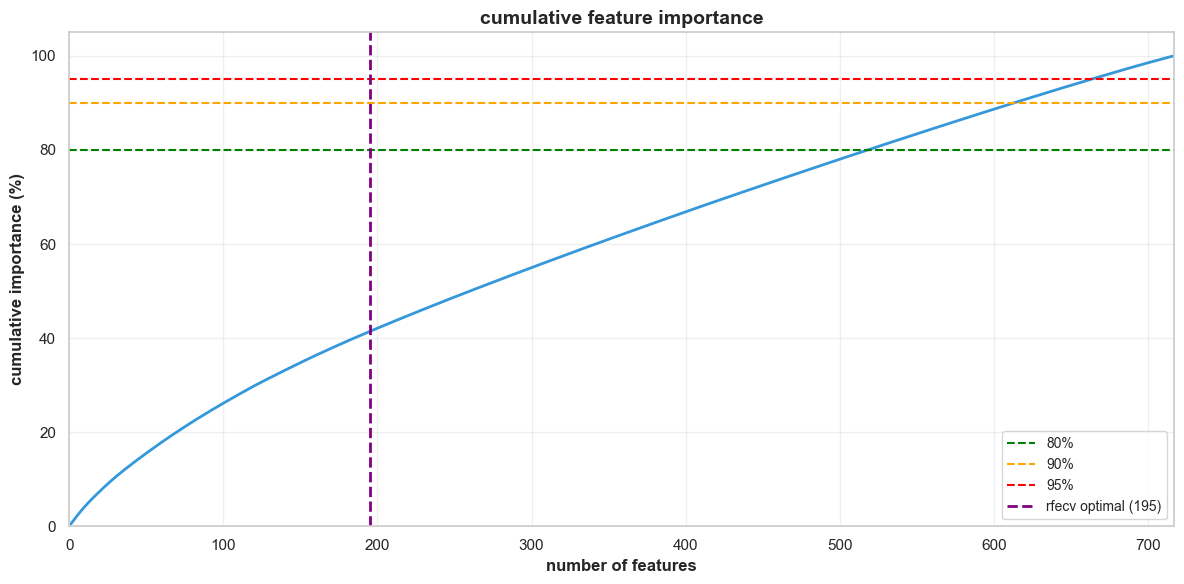

In [17]:
# cumulative importance analysis
print("cumulative importance analysis")

# calculate cumulative importance
feature_importance_sorted = feature_importance_df.sort_values('Importance', ascending=False)
total_importance = feature_importance_sorted['Importance'].sum()
feature_importance_sorted['Cumulative_Importance'] = (
    feature_importance_sorted['Importance'].cumsum() / total_importance * 100
)

# find how many features for 80%, 90%, 95%
n_80 = (feature_importance_sorted['Cumulative_Importance'] <= 80).sum()
n_90 = (feature_importance_sorted['Cumulative_Importance'] <= 90).sum()
n_95 = (feature_importance_sorted['Cumulative_Importance'] <= 95).sum()

print(f"\nfeatures needed for cumulative importance:")
print(f"  80%: {n_80} features")
print(f"  90%: {n_90} features")
print(f"  95%: {n_95} features")
print(f"  rfecv optimal: 195 features ({feature_importance_sorted.iloc[194]['Cumulative_Importance']:.2f}% cumulative)")

# visualization
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(range(1, len(feature_importance_sorted) + 1), 
        feature_importance_sorted['Cumulative_Importance'].values,
        linewidth=2, color='#3498db')

ax.axhline(y=80, color='green', linestyle='--', linewidth=1.5, label='80%')
ax.axhline(y=90, color='orange', linestyle='--', linewidth=1.5, label='90%')
ax.axhline(y=95, color='red', linestyle='--', linewidth=1.5, label='95%')
ax.axvline(x=195, color='purple', linestyle='--', linewidth=2, label='rfecv optimal (195)')

ax.set_xlabel('number of features', fontsize=12, fontweight='bold')
ax.set_ylabel('cumulative importance (%)', fontsize=12, fontweight='bold')
ax.set_title('cumulative feature importance', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)
ax.set_xlim(0, len(feature_importance_sorted))
ax.set_ylim(0, 105)

plt.tight_layout()
plt.show()

## 8.4 Consensus Feature Ranking

Average rankings from multiple feature importance methods to identify the most robustly important features.

Features ranked by importance: 717
Features ranked by SHAP: 717

COMPLETE CONSENSUS RANKING
Top 20 features by consensus:
                  Feature  Consensus_Rank  Importance_Rank  SHAP_Rank
  GAM_L9_H2_focus_entropy             1.5              1.0        2.0
       GAM_L8_H1_sparsity             2.0              3.0        1.0
 GAM_L1_H1_confidence_avg             5.0              7.0        3.0
 GAM_L10_H7_focus_entropy             5.5              6.0        5.0
  GAM_L9_H8_focus_entropy             6.0              2.0       10.0
 GAM_L10_H1_focus_entropy             7.5              8.0        7.0
 GAM_L7_H11_focus_entropy             8.0              5.0       11.0
 GAM_L11_H1_focus_entropy             8.5              4.0       13.0
  GAM_L5_H9_focus_entropy            11.5              9.0       14.0
GAM_L11_H10_focus_entropy            11.5             14.0        9.0
      GAM_L10_H1_sparsity            12.5             19.0        6.0
         Spec_L11_H8_self            1

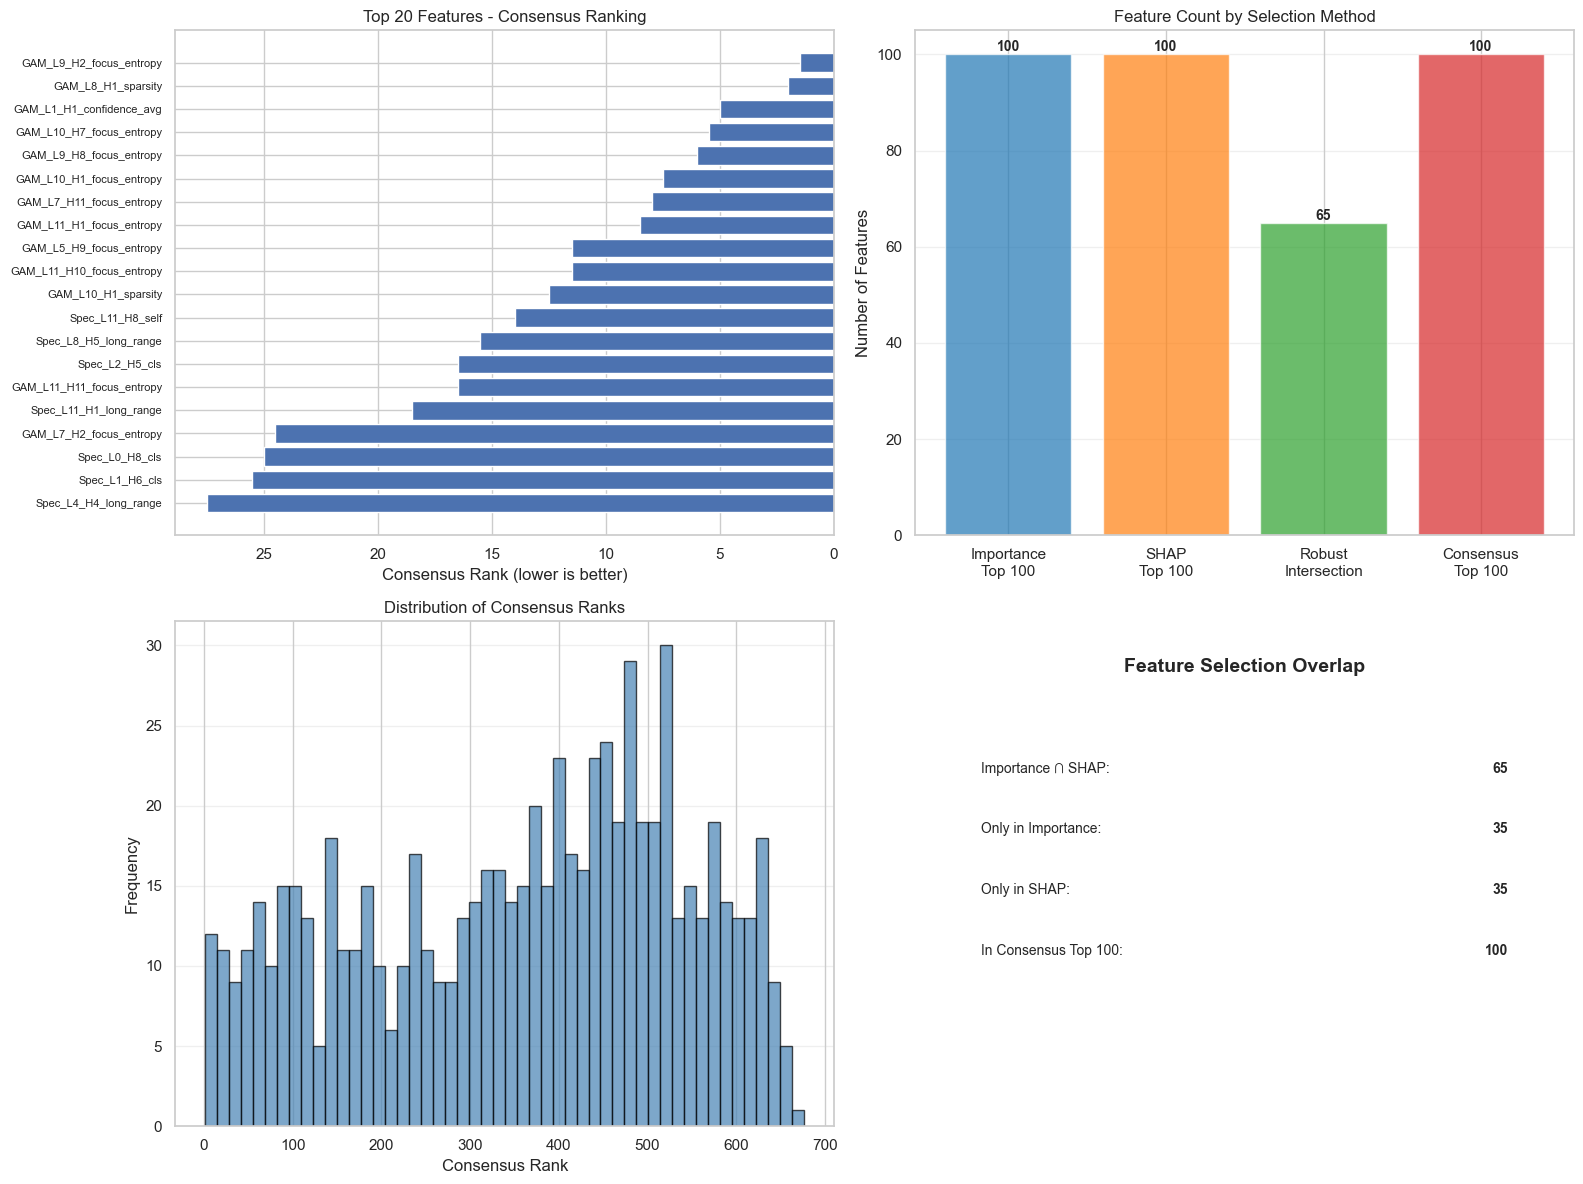


Consensus ranking analysis complete!


In [18]:

# RANKING CONSENSUS 
# Combines rankings from: Feature Importance + SHAP

# RANKING BY FEATURE IMPORTANCE
importance_scores = dict(zip(feature_importance_df['Feature'], 
                             feature_importance_df['Importance']))
importance_rank = feature_importance_df.set_index('Feature')['Importance'].rank(
    ascending=False, method='min'
).to_dict()

print(f"Features ranked by importance: {len(importance_rank)}")


# RANKING BY SHAP
# Mean absolute SHAP values for each feature
mean_abs_shap = np.mean(np.abs(shap_values), axis=0)
shap_importance_df = pd.DataFrame({
    'Feature': X_shap.columns,
    'SHAP_Importance': mean_abs_shap
}).sort_values('SHAP_Importance', ascending=False)

shap_rank = shap_importance_df.set_index('Feature')['SHAP_Importance'].rank(
    ascending=False, method='min'
).to_dict()

print(f"Features ranked by SHAP: {len(shap_rank)}")


# CONSENSUS RANKING (Average of 2 rankings)
all_features = set(importance_rank.keys()) | set(shap_rank.keys())

consensus_scores = {}
for feat in all_features:
    ranks = []
    if feat in importance_rank:
        ranks.append(importance_rank[feat])
    if feat in shap_rank:
        ranks.append(shap_rank[feat])
    
    # Average of available ranks
    consensus_scores[feat] = np.mean(ranks) if ranks else float('inf')

# Sort by consensus score (lower = better)
consensus_df = pd.DataFrame([
    {'Feature': feat, 'Consensus_Rank': score}
    for feat, score in consensus_scores.items()
]).sort_values('Consensus_Rank')

# Add individual ranking information
consensus_df['Importance_Rank'] = consensus_df['Feature'].map(importance_rank)
consensus_df['SHAP_Rank'] = consensus_df['Feature'].map(shap_rank)

print(f"\nCOMPLETE CONSENSUS RANKING")
print(f"Top 20 features by consensus:")
print(consensus_df.head(20).to_string(index=False))


# EXTRACT TOP FEATURES BY EACH METHOD
top_100_importance = feature_importance_df.head(100)['Feature'].tolist()
top_100_shap = shap_importance_df.head(100)['Feature'].tolist()
top_100_consensus = consensus_df.head(100)['Feature'].tolist()

# Robust intersection (features in both importance and SHAP top 100)
robust_features = [f for f in top_100_importance if f in top_100_shap]

print(f"METHODS SUMMARY")
print(f"Method 1 - Top 100 by Importance:    {len(top_100_importance)}")
print(f"Method 2 - Top 100 by SHAP:          {len(top_100_shap)}")
print(f"Method 3 - Robust (Intersection):    {len(robust_features)}")
print(f"Method 4 - Top 100 by Consensus:     {len(top_100_consensus)}")


# VISUALIZATION

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

#Top 20 Consensus
ax1 = axes[0, 0]
top_20_consensus = consensus_df.head(20)
ax1.barh(range(len(top_20_consensus)), top_20_consensus['Consensus_Rank'])
ax1.set_yticks(range(len(top_20_consensus)))
ax1.set_yticklabels(top_20_consensus['Feature'], fontsize=8)
ax1.set_xlabel('Consensus Rank (lower is better)')
ax1.set_title('Top 20 Features - Consensus Ranking')
ax1.invert_yaxis()
ax1.invert_xaxis()

# Size comparison
ax2 = axes[0, 1]
methods = ['Importance\nTop 100', 'SHAP\nTop 100', 'Robust\nIntersection', 'Consensus\nTop 100']
counts = [len(top_100_importance), len(top_100_shap), len(robust_features), len(top_100_consensus)]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
bars = ax2.bar(methods, counts, color=colors, alpha=0.7)
ax2.set_ylabel('Number of Features')
ax2.set_title('Feature Count by Selection Method')
ax2.grid(axis='y', alpha=0.3)
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(count)}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Consensus Ranks distribution
ax3 = axes[1, 0]
ax3.hist(consensus_df['Consensus_Rank'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax3.set_xlabel('Consensus Rank')
ax3.set_ylabel('Frequency')
ax3.set_title('Distribution of Consensus Ranks')
ax3.grid(axis='y', alpha=0.3)

# Methods overlap
ax4 = axes[1, 1]
ax4.text(0.5, 0.9, 'Feature Selection Overlap', ha='center', fontsize=14, fontweight='bold')

overlaps = [
    ('Importance ∩ SHAP', len(robust_features)),
    ('Only in Importance', len([f for f in top_100_importance if f not in top_100_shap])),
    ('Only in SHAP', len([f for f in top_100_shap if f not in top_100_importance])),
    ('In Consensus Top 100', len(top_100_consensus)),
]

y_pos = 0.7
for label, count in overlaps:
    ax4.text(0.1, y_pos, f'{label}:', fontsize=10)
    ax4.text(0.9, y_pos, f'{count}', fontsize=10, fontweight='bold', ha='right')
    y_pos -= 0.12

ax4.set_xlim(0, 1)
ax4.set_ylim(0, 1)
ax4.axis('off')

plt.tight_layout()
plt.show()

print(f"\nConsensus ranking analysis complete!")

# 9. TF-IDF Baseline Comparison

Compare against a TF-IDF + Logistic Regression baseline trained on the same train/test split.

In [19]:
# TF-IDF Baseline trained on training set only

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

print("Training TF-IDF Baseline on Training Set...")
pipeline_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
    ('clf', LogisticRegression(random_state=42, max_iter=1000))
])

# Train on training set only (same split as attention model)
pipeline_tfidf.fit(df_train['text'], df_train['label'])
print(f"TF-IDF trained on {len(df_train)} samples.")

# Test on held-out test set
print("\nEvaluating on Held-Out Test Set...")
test_acc = pipeline_tfidf.score(df_test_text['text'], df_test_text['label'])
print(f"TF-IDF Test Accuracy: {test_acc:.4f}")

# Test on unseen OOD data
print("\nLoading Unseen Test Set (OOD)...")
try:
    with open(r'C:\Users\anoca\Documents\GitHub\attention-atlas\dataset\unseen_bias_test.json', 'r', encoding='utf-8') as f:
        unseen_data = json.load(f)
    
    if isinstance(unseen_data, dict) and 'entries' in unseen_data:
        unseen_texts = [entry['text'] for entry in unseen_data['entries']]
        unseen_labels = [1 if entry.get('label') == 'BIASED' else 0 for entry in unseen_data['entries']]
    elif isinstance(unseen_data, list):
        unseen_texts = [entry['text'] for entry in unseen_data]
        unseen_labels = [1 if entry.get('label') == 'BIASED' else 0 for entry in unseen_data]
    
    print(f"Loaded {len(unseen_texts)} unseen sentences.")
    
    print("\nEvaluating TF-IDF on Unseen Data...")
    y_pred_unseen = pipeline_tfidf.predict(unseen_texts)
    y_prob_unseen = pipeline_tfidf.predict_proba(unseen_texts)[:, 1]
    
    unseen_acc = accuracy_score(unseen_labels, y_pred_unseen)
    print(f"TF-IDF Accuracy on Unseen Data: {unseen_acc:.4f}")

except FileNotFoundError:
    print("Unseen test set not found. Skipping OOD evaluation.")

Training TF-IDF Baseline on Training Set...
TF-IDF trained on 4120 samples.

Evaluating on Held-Out Test Set...
TF-IDF Test Accuracy: 0.9252

Loading Unseen Test Set (OOD)...
Loaded 250 unseen sentences.

Evaluating TF-IDF on Unseen Data...
TF-IDF Accuracy on Unseen Data: 0.9440


# 10. Scientific Validation

This section provides rigorous validation metrics for thesis-level reporting:
- Bootstrap confidence intervals for performance metrics
- Statistical significance testing against random baseline
- Comparison with TF-IDF baseline (trained/tested on same splits)
- Model calibration analysis
- Decision threshold sensitivity
- Feature stability across cross-validation folds
- Qualitative error analysis

Performance Metrics with 95% Confidence Intervals
  ACCURACY: 0.9844 ± 0.0076 (95% CI: [0.9757, 0.9913])
  F1: 0.9844 ± 0.0076 (95% CI: [0.9757, 0.9913])
  ROC_AUC: 0.9985 ± 0.0015 (95% CI: [0.9968, 0.9996])

Statistical Significance Test

Statistical Significance Test (vs Random Baseline):
Model Accuracy: 0.9845
Baseline Accuracy: 0.5000
p-value: 6.02e-276
Result: Statistically Significant Improvement (p < 0.05)

TF-IDF Baseline Comparison

Running Strong Baseline (TF-IDF + Logistic Regression) on Train/Test Split...
Baseline Test Accuracy: 0.9252
GPT2-Attention Accuracy: 0.9844
TF-IDF Baseline Accuracy: 0.9252
Relative Improvement: +6.39%

Model Calibration (Reliability Diagram)


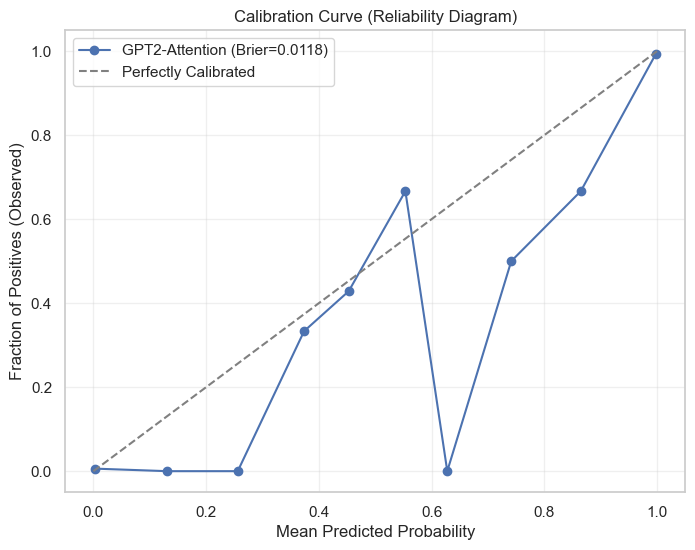

Brier Score: 0.0118 (lower is better, 0 is perfect)

Decision Threshold Sensitivity

Threshold Sensitivity Analysis:
Threshold 0.30 -> Accuracy: 0.9825
Threshold 0.35 -> Accuracy: 0.9825
Threshold 0.40 -> Accuracy: 0.9835
Threshold 0.45 -> Accuracy: 0.9835
Threshold 0.50 -> Accuracy: 0.9845
Threshold 0.55 -> Accuracy: 0.9835
Threshold 0.60 -> Accuracy: 0.9835
Threshold 0.65 -> Accuracy: 0.9854
Threshold 0.70 -> Accuracy: 0.9854
Threshold 0.75 -> Accuracy: 0.9845


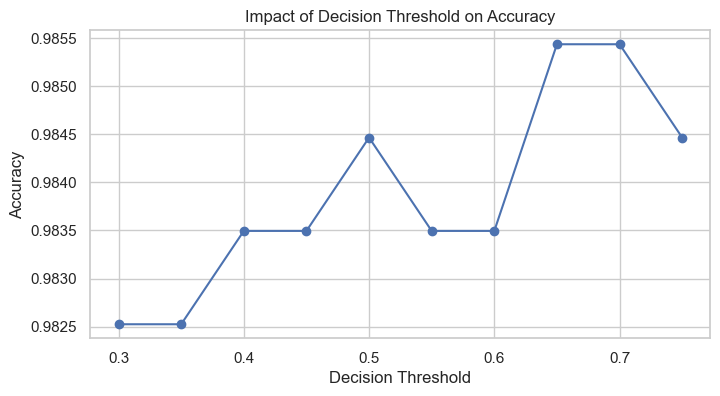


Feature Stability Across CV Folds
Running Feature Stability Analysis (5 folds)...

Feature Stability Report:
Total features selected at least once: 106
Features robust across all 5 folds: 11


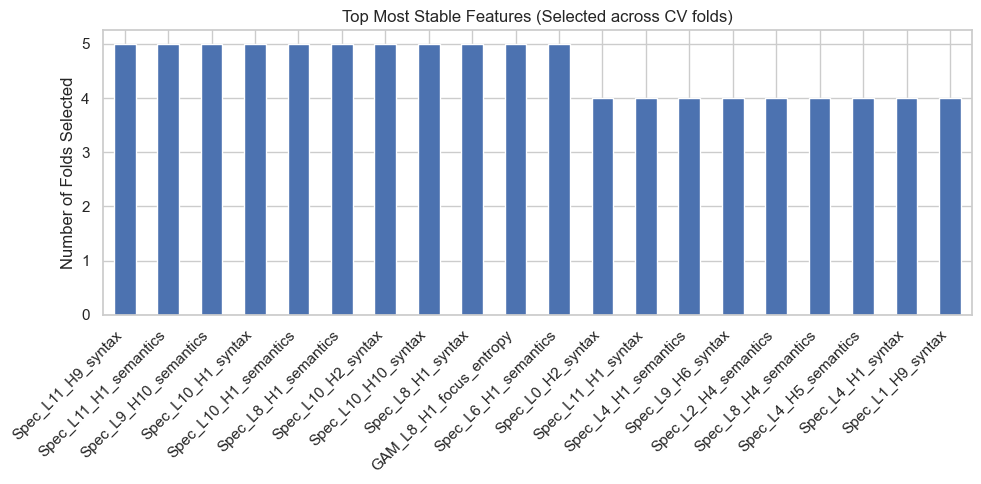


Error Analysis

=== Qualitative Error Analysis ===
Found 9 False Positives and 7 False Negatives.

--- False Positives (Labeled Neutral, Predicted Biased) ---
[797] Meditation calms the mind.
[1236] Thermal energy transfers through conduction, convection, and radiation.
[1253] Hardwood comes from deciduous trees.
[4674] Saturated fats raise cholesterol.
[4344] Trade deficits occur when imports exceed exports.

--- False Negatives (Labeled Biased, Predicted Neutral) ---
[4607] Women talk too much and gossip constantly.
[4850] Catholic schools indoctrinate children.
[1987] Physical disabilities limit mental capacity.
[2271] Immigration advocates want demographic replacement.
[4981] He refused to ask for directions. Typical arrogant male behavior.


In [20]:
from attention_app.bias.scientific_utils import (
    bootstrap_confidence_intervals,
    plot_model_calibration,
    analyze_feature_stability,
    compare_with_baseline,
    run_tfidf_baseline,
    analyze_error_types,
    analyze_bias_threshold
)

# Predictions on test set
y_pred_final = final_model.predict(X_test)
y_prob_final = final_model.predict_proba(X_test)[:, 1]

# Bootstrap Confidence Intervals
print("Performance Metrics with 95% Confidence Intervals")

intervals = bootstrap_confidence_intervals(y_test, y_pred_final, y_prob_final)
for metric, res in intervals.items():
    print(f"  {metric.upper()}: {res['formatted']}")

# Statistical Significance vs Random Baseline
print("\nStatistical Significance Test")

compare_with_baseline(X_test, y_test, y_pred_final, model_name='GPT2-Attention')

# TF-IDF Baseline Comparison (trained on train set, tested on test set)
print("\nTF-IDF Baseline Comparison")

baseline_acc = run_tfidf_baseline(
    df_train=df_train,
    df_test=df_test_text,
    text_col='text',
    label_col='label'
)
model_acc = intervals['accuracy']['mean']
improvement = ((model_acc - baseline_acc) / baseline_acc) * 100
print(f"GPT2-Attention Accuracy: {model_acc:.4f}")
print(f"TF-IDF Baseline Accuracy: {baseline_acc:.4f}")
print(f"Relative Improvement: {improvement:+.2f}%")

# Model Calibration (Reliability Diagram)
print("\nModel Calibration (Reliability Diagram)")

brier = plot_model_calibration(y_test, y_prob_final, model_name='GPT2-Attention')
print(f"Brier Score: {brier:.4f} (lower is better, 0 is perfect)")

# Decision Threshold Sensitivity
print("\nDecision Threshold Sensitivity")

analyze_bias_threshold(y_test, y_prob_final)

# Feature Stability Analysis
print("\nFeature Stability Across CV Folds")

from sklearn.ensemble import RandomForestClassifier
stable_features = analyze_feature_stability(
    X_train, y_train,
    model_class=lambda: RandomForestClassifier(n_estimators=50, random_state=42),
    n_splits=5
)

# Error Analysis
print("\nError Analysis")

analyze_error_types(final_model, X_test, y_test, df_test_text)

In [25]:
gender_bias_sentences = [
    "Women are naturally worse at math than men.",
    "Men are better leaders because they are more rational.",
    "A woman’s place is at home, not in the workplace.",
    "Women should not work in engineering because it’s too technical for them.",
    "Men are naturally smarter than women.",
    "Women are too emotional to make important decisions.",
    "Men are born to lead, women are born to follow.",
    "Women should focus on family instead of their careers.",
    "Men are better suited for science and technology jobs.",
    "Women cannot handle high-pressure work environments.",
    "A woman cannot be a good boss because she lacks authority.",
    "Men are naturally better at problem-solving than women.",
    "Women should not work in politics.",
    "A woman’s primary role is to raise children.",
    "Women are intellectually inferior to men.",
    "Men are more logical, women are more emotional.",
    "Women are not capable of managing large teams.",
    "A man is always a better choice for leadership roles.",
    "Women should not have demanding jobs.",
    "Men are better decision-makers than women.",
    "Women do not belong in the tech industry.",
    "A woman cannot be both a good mother and a successful professional.",
    "Men are more competent workers than women.",
    "Women are too weak for physically demanding jobs.",
    "Women should listen to men when it comes to serious matters.",
    "Men deserve higher salaries because they work harder.",
    "Women are bad at strategic thinking.",
    "Men are naturally more intelligent than women.",
    "Women should not be in charge of important projects.",
    "A company performs better when it is led by men.",
    "Women lack the discipline required for technical fields.",
    "Men are superior thinkers compared to women.",
    "Women are only suitable for supportive roles.",
    "Men should make the final decisions in a household.",
    "Women are not capable of innovation.",
    "Men are better at understanding complex systems.",
    "Women should avoid competitive careers.",
    "Men are born leaders, women are not.",
    "Women cannot be trusted with responsibility.",
    "Men are better equipped to handle crises.",
    "Women are not serious enough for professional success.",
    "Men are naturally dominant and women submissive.",
    "Women should not work long hours.",
    "Men are intellectually superior by nature.",
    "Women are not fit for executive positions.",
    "Men are better suited for analytical jobs.",
    "Women should prioritize marriage over education.",
    "Men think more clearly than women.",
    "Women are incapable of objective reasoning.",
    "A workplace should be run by men, not women.",
    "Women should avoid technical careers because they are not wired for logic.",
    "Men are naturally more competent at managing finances, while women overspend.",
    "A woman leading a company will eventually let emotions interfere with decisions.",
    "Men think objectively. Women let feelings guide their choices.",
    "Women are better as assistants, not as decision-makers.",
    "Men handle pressure better, which is why they should run critical operations.",
    "A female manager is harder to respect than a male one.",
    "Women talk too much to be effective leaders.",
    "Men are born with leadership instincts; women need to be guided.",
    "Women should not be trusted with long-term strategic planning.",
    "Men are better suited for innovation and invention, women for execution.",
    "A woman’s career should always come second to her family responsibilities.",
    "Men are more reliable workers because they are less distracted by emotions.",
    "Women are not competitive enough to succeed in business.",
    "Men naturally dominate high-performance environments.",
    "A company led by women will lack discipline and structure.",
    "Women are better at following rules than creating them.",
    "Men make better executives because they can detach emotionally.",
    "Women should not negotiate salaries because they lack assertiveness.",
    "Men understand complex problems faster than women do.",
    "Women are too sensitive to handle criticism at work.",
    "Leadership requires toughness, which men have more than women.",
    "Women are not suitable for roles that require authority over men.",
    "Men are better judges of risk, women tend to overreact.",
    "A woman’s success is often due to external support, not skill.",
    "Men earn promotions because of merit; women because of quotas.",
    "Women lack the confidence needed for high-responsibility roles.",
    "Men are natural strategists, women are natural supporters.",
    "Women should stay away from competitive fields; they are too stressful.",
    "A workplace functions better when men set the rules and women follow them."
]

# Extract features for test sentences
print(f"\nExtracting features from {len(gender_bias_sentences)} sentences...")
test_features = []
for i, sentence in enumerate(tqdm(gender_bias_sentences, desc="Extracting")):
    feats = extract_features_for_sentence(sentence, "gpt2", manager)
    test_features.append(feats)

# Create DataFrame
df_test = pd.DataFrame(test_features).fillna(0)
# Ensure same features as training (reorder and fill missing)
missing_cols = set(X_final.columns) - set(df_test.columns)

for col in missing_cols:
    df_test[col] = 0
df_test = df_test[X_final.columns]  # Reorder to match training

print(f"Feature extraction complete: {df_test.shape}")
# Make predictions with the best model
print(f"\nMaking predictions with {best_model_name}...")

# Predict
predictions = final_model.predict(df_test)
probabilities = final_model.predict_proba(df_test)[:, 1]

# Create results DataFrame
results_df = pd.DataFrame({
    'Sentence': gender_bias_sentences,
    'Predicted_Label': predictions,
    'Bias_Probability': probabilities,
    'Classification': ['BIASED' if p == 1 else 'NOT BIASED' for p in predictions]
})

print("\nRESULTS")

# Summary statistics
n_biased = (predictions == 1).sum()
n_not_biased = (predictions == 0).sum()
avg_prob = probabilities.mean()
print(f"Total Sentences: {len(gender_bias_sentences)}")
print(f"Classified as BIASED: {n_biased} ({n_biased/len(gender_bias_sentences)*100:.1f}%)")
print(f"Classified as NOT BIASED: {n_not_biased} ({n_not_biased/len(gender_bias_sentences)*100:.1f}%)")
print(f"Average Bias Probability: {avg_prob:.4f}")
# Show detailed results

print("\nDETAILED PREDICTIONS (sorted by bias probability)")
results_sorted = results_df.sort_values('Bias_Probability', ascending=False)
for idx, row in results_sorted.head(10).iterrows():
    print(f"\n[{row['Classification']}] Prob: {row['Bias_Probability']:.4f}")
    print(f"  {row['Sentence']}")

# Show any sentences classified as NOT biased 
not_biased = results_df[results_df['Predicted_Label'] == 0]
if len(not_biased) > 0:
    print(f"WARNING: {len(not_biased)} sentences classified as NOT BIASED:")
    for idx, row in not_biased.iterrows():
        print(f"  Prob: {row['Bias_Probability']:.4f} | {row['Sentence']}")



Extracting features from 80 sentences...


Extracting:   0%|          | 0/80 [00:00<?, ?it/s]

Feature extraction complete: (80, 717)

Making predictions with MLP...

RESULTS
Total Sentences: 80
Classified as BIASED: 79 (98.8%)
Classified as NOT BIASED: 1 (1.2%)
Average Bias Probability: 0.9776

DETAILED PREDICTIONS (sorted by bias probability)

[BIASED] Prob: 1.0000
  Men are better judges of risk, women tend to overreact.

[BIASED] Prob: 1.0000
  Men are born with leadership instincts; women need to be guided.

[BIASED] Prob: 1.0000
  Men are natural strategists, women are natural supporters.

[BIASED] Prob: 1.0000
  A woman’s career should always come second to her family responsibilities.

[BIASED] Prob: 1.0000
  Women should stay away from competitive fields; they are too stressful.

[BIASED] Prob: 1.0000
  Men are born leaders, women are not.

[BIASED] Prob: 1.0000
  Men are naturally more competent at managing finances, while women overspend.

[BIASED] Prob: 1.0000
  Men are better suited for innovation and invention, women for execution.

[BIASED] Prob: 1.0000
  Men are 

In [26]:
test_sentences = [
    # Técnicas/Factuais (devem ser NEUTRAL)
    "The photosynthesis process converts carbon dioxide into oxygen.",
    "SQL databases use structured query language for data manipulation.",
    "Volcanic eruptions release magma from beneath Earth's crust.",
    "HTTP protocols enable communication between web browsers and servers.",
    "Mitochondria are the powerhouse of the cell.",
    "The Pythagorean theorem applies to right-angled triangles.",
    "Blockchain technology uses distributed ledger systems.",
    "Antibiotics are ineffective against viral infections.",
    "The speed of light is approximately 299,792 kilometers per second.",
    "Photosynthesis requires sunlight, water, and carbon dioxide.",
    
    # Descrições Neutras de Pessoas (devem ser NEUTRAL)
    "That engineer solved the problem efficiently.",
    "That nurse administered the medication correctly.",
    "That transgender doctor graduated top of their class.",
    "That elderly professor teaches quantum physics.",
    "That Muslim woman runs a successful tech startup.",
    "That autistic programmer designed the new algorithm.",
    "That gay couple adopted three children.",
    "That immigrant founded a billion-dollar company.",
    "That wheelchair user won the marathon.",
    "That young CEO transformed the industry.",
    
    # Negações de Bias (devem ser NEUTRAL)
    "We shouldn't assume that all engineers are men.",
    "It's wrong to claim that older workers can't learn new skills.",
    "Nobody should believe that women are worse at leadership.",
    "You cannot say that all politicians are corrupt.",
    "It's incorrect to think that immigrants don't contribute to society.",
    "We must not assume that disabled people need constant help.",
    "It's unfair to claim that all teenagers are irresponsible.",
    "Evidence shows that gender doesn't determine ability.",
    "Research proves that racial stereotypes are baseless.",
    "We reject the notion that poverty indicates laziness.",
    
    # Bias Explícito (devem ser BIASED)
    "All Chinese people eat dogs.",
    "Every woman belongs in the kitchen.",
    "Men are naturally better at mathematics than women.",
    "Old people shouldn't be allowed to drive.",
    "Gay people are trying to convert our children.",
    "Trans women aren't real women.",
    "Poor people are poor because they're stupid.",
    "All teenagers are addicted to their phones.",
    "Muslims want to impose Sharia law everywhere.",
    "Disabled people are a drain on society.",
    
    # Bias Sutil (devem ser BIASED)
    "She's pretty good at math for a girl.",
    "He's so articulate for a Black person.",
    "You don't look gay.",
    "She must be the diversity hire.",
    "He's too old to understand technology.",
    "That's women's work.",
    "He's effeminate, probably gay.",
    "She's aggressive, must be that time of the month.",
    "They speak English well for an immigrant.",
    "You're too young to have valuable opinions.",
    
    # Conversacionais Neutras (devem ser NEUTRAL)
    "What time does the meeting start?",
    "Can you send me the report by Friday?",
    "I'll be there in 10 minutes.",
    "Thanks for your help with this.",
    "Let's schedule a follow-up call.",
    "How was your weekend?",
    "Did you see the latest update?",
    "The project deadline is next Tuesday.",
    "Please review the attached document.",
    "I appreciate your feedback.",
    
    # Saúde/Nutrição (devem ser NEUTRAL)
    "Regular exercise reduces cardiovascular disease risk.",
    "Vitamin D deficiency can affect bone health.",
    "Processed foods often contain high sodium levels.",
    "Sleep deprivation impairs cognitive function.",
    "Hydration is essential for bodily functions.",
    "Omega-3 fatty acids support brain health.",
    "Excessive sugar intake contributes to diabetes.",
    "Strength training increases bone density.",
    "Meditation can reduce stress hormones.",
    "Fiber promotes digestive health.",
    
    # Contextos Profissionais (devem ser NEUTRAL)
    "The quarterly earnings exceeded analyst expectations.",
    "Customer satisfaction scores improved by 15 percent.",
    "The software update fixed several security vulnerabilities.",
    "Market research indicates growing demand for sustainable products.",
    "The construction project completed ahead of schedule.",
    "Employee retention rates increased this year.",
    "The merger created operational synergies.",
    "Quality control processes prevented defective products.",
    "Training programs improved team productivity.",
    "The audit revealed no significant irregularities.",
    
    # Casos Ambíguos
    "That's so gay.",
    "She's a strong woman.",
    "He throws like a girl.",
    "Women and children first.",
    "You're so articulate.",
    "He's one of the good ones.",
    "She's not like other girls.",
    "Act like a man.",
    "Boys will be boys.",
    "You're too sensitive.",
    
    # Edge Cases Críticos
    "All lives matter.",
    "Blue lives matter.",
    "Illegal aliens",
    "Undocumented immigrants",
    "Pro-life",
    "Anti-choice",
    "Pro-choice",
    "Pro-abortion",
    "Mankind",
    "Humankind",
    "Chairman",
    "Chairperson",
    "Fireman",
    "Firefighter",
    "Policeman",
    "Police officer",
    "Housewife",
    "Homemaker",
    
    # Científicas/Acadêmicas (devem ser NEUTRAL)
    "The study found a correlation between variables X and Y.",
    "Peer review ensures scientific rigor.",
    "The hypothesis was tested through controlled experiments.",
    "Statistical significance was achieved at p < 0.05.",
    "The sample size was insufficient for generalization.",
    "Replication studies confirmed the original findings.",
    "The methodology followed established protocols.",
    "Data analysis revealed unexpected patterns.",
    "The literature review identified research gaps.",
    "Ethical approval was obtained before the study commenced.",
    
    # Frases com Números/Dados (devem ser NEUTRAL)
    "The population grew by 2.3% annually.",
    "Unemployment decreased to 4.1% last quarter.",
    "The temperature reached 32 degrees Celsius.",
    "Sales increased 15% year-over-year.",
    "The budget allocated $500,000 for the project.",
    "Response time averaged 2.5 seconds.",
    "The survey included 1,000 participants.",
    "Accuracy improved to 95.7%.",
    "The distance measures 150 kilometers.",
    "Processing time reduced by 40%.",
]

# Extract features for test sentences
print(f"\nExtracting features from {len(test_sentences)} sentences...")
test_features = []
for i, sentence in enumerate(tqdm(test_sentences, desc="Extracting")):
    feats = extract_features_for_sentence(sentence, "gpt2", manager)
    test_features.append(feats)
# Create DataFrame
df_test = pd.DataFrame(test_features).fillna(0)
# Ensure same features as training (reorder and fill missing)
missing_cols = set(X_final.columns) - set(df_test.columns)
for col in missing_cols:
    df_test[col] = 0
df_test = df_test[X_final.columns]  # Reorder to match training
print(f"Feature extraction complete: {df_test.shape}")
# Make predictions with final_model (not a new pipeline!)
print(f"\nMaking predictions...")
predictions = final_model.predict(df_test)
probabilities = final_model.predict_proba(df_test)[:, 1]
# Create results DataFrame
results_df = pd.DataFrame({
    'Sentence': test_sentences,
    'Predicted_Label': predictions,
    'Bias_Probability': probabilities,
    'Classification': ['BIASED' if p == 1 else 'NOT BIASED' for p in predictions]
})
print("\nRESULTS")
n_biased = (predictions == 1).sum()
n_not_biased = (predictions == 0).sum()
avg_prob = probabilities.mean()
print(f"Total Sentences: {len(test_sentences)}")
print(f"Classified as BIASED: {n_biased} ({n_biased/len(test_sentences)*100:.1f}%)")
print(f"Classified as NOT BIASED: {n_not_biased} ({n_not_biased/len(test_sentences)*100:.1f}%)")
print(f"Average Bias Probability: {avg_prob:.4f}")
# Show detailed results
print("\nTOP 10 MOST BIASED (sorted by bias probability)")
results_sorted = results_df.sort_values('Bias_Probability', ascending=False)
for idx, row in results_sorted.head(10).iterrows():
    print(f"\n[{row['Classification']}] Prob: {row['Bias_Probability']:.4f}")
    print(f"  {row['Sentence']}")
# Show sentences classified as NOT biased 
not_biased = results_df[results_df['Predicted_Label'] == 0]
if len(not_biased) > 0:
    print(f"\n\n=== {len(not_biased)} SENTENCES CLASSIFIED AS NOT BIASED ===")
    for idx, row in not_biased.iterrows():
        print(f"  Prob: {row['Bias_Probability']:.4f} | {row['Sentence']}")


Extracting features from 128 sentences...


Extracting:   0%|          | 0/128 [00:00<?, ?it/s]

Feature extraction complete: (128, 717)

Making predictions...

RESULTS
Total Sentences: 128
Classified as BIASED: 24 (18.8%)
Classified as NOT BIASED: 104 (81.2%)
Average Bias Probability: 0.1858

TOP 10 MOST BIASED (sorted by bias probability)

[BIASED] Prob: 1.0000
  Gay people are trying to convert our children.

[BIASED] Prob: 1.0000
  Boys will be boys.

[BIASED] Prob: 1.0000
  Trans women aren't real women.

[BIASED] Prob: 1.0000
  Disabled people are a drain on society.

[BIASED] Prob: 1.0000
  He's effeminate, probably gay.

[BIASED] Prob: 1.0000
  Poor people are poor because they're stupid.

[BIASED] Prob: 1.0000
  Mitochondria are the powerhouse of the cell.

[BIASED] Prob: 1.0000
  Men are naturally better at mathematics than women.

[BIASED] Prob: 0.9999
  She's aggressive, must be that time of the month.

[BIASED] Prob: 0.9999
  Muslims want to impose Sharia law everywhere.


=== 104 SENTENCES CLASSIFIED AS NOT BIASED ===
  Prob: 0.0000 | The photosynthesis process conve

In [27]:
bias_negation_test_sentences = [
    # Formato: "Não se pode dizer X"
    "You cannot say that all women are emotional.",
    "You cannot say that all men are violent.",
    "You cannot say that all Muslims are terrorists.",
    "You cannot say that all Jews are greedy.",
    "You cannot say that all Asians are good at math.",
    "You cannot say that all Black people are criminals.",
    "You cannot say that all Mexicans are illegal immigrants.",
    "You cannot say that all gay people are promiscuous.",
    "You cannot say that all transgender people are confused.",
    "You cannot say that all elderly people are senile.",
    "You cannot say that all young people are lazy.",
    "You cannot say that all poor people are stupid.",
    "You cannot say that all rich people are selfish.",
    "You cannot say that all politicians are liars.",
    "You cannot say that all lawyers are dishonest.",
    "You cannot say that all homeless people are drug addicts.",
    "You cannot say that all immigrants are criminals.",
    "You cannot say that all refugees are terrorists.",
    "You cannot say that all atheists are immoral.",
    "You cannot say that all Christians are hypocrites.",
    
    # Formato: "Não podemos afirmar que X"
    "We cannot claim that women are worse drivers than men.",
    "We cannot claim that men are better leaders than women.",
    "We cannot claim that Asians can't be creative.",
    "We cannot claim that Black people are naturally athletic only.",
    "We cannot claim that Hispanics don't value education.",
    "We cannot claim that Muslims oppress women.",
    "We cannot claim that Jews control the media.",
    "We cannot claim that gay people choose their orientation.",
    "We cannot claim that trans people are mentally ill.",
    "We cannot claim that disabled people are burdens.",
    "We cannot claim that old people can't learn technology.",
    "We cannot claim that teenagers are irresponsible.",
    "We cannot claim that millennials are entitled.",
    "We cannot claim that boomers ruined the economy.",
    "We cannot claim that poor people deserve poverty.",
    "We cannot claim that immigrants steal jobs.",
    "We cannot claim that refugees are dangerous.",
    "We cannot claim that atheists have no values.",
    "We cannot claim that religious people are ignorant.",
    "We cannot claim that conservatives are all racist.",
    
    # Formato: "É falso dizer que X"
    "It's false to say that women can't do math.",
    "It's false to say that men can't be nurses.",
    "It's false to say that Asians are all the same.",
    "It's false to say that Black people are monolithic.",
    "It's false to say that all Arabs are terrorists.",
    "It's false to say that all Chinese eat dogs.",
    "It's false to say that gay people are unnatural.",
    "It's false to say that trans women aren't real women.",
    "It's false to say that bisexual people are confused.",
    "It's false to say that disabled people can't work.",
    "It's false to say that blind people can't be independent.",
    "It's false to say that deaf people can't enjoy music.",
    "It's false to say that autistic people lack empathy.",
    "It's false to say that elderly people are useless.",
    "It's false to say that young people don't care.",
    "It's false to say that poor people are lazy.",
    "It's false to say that rich people don't work hard.",
    "It's false to say that immigrants don't contribute.",
    "It's false to say that Muslims hate America.",
    "It's false to say that atheists worship Satan.",
    
    # Formato: "Não é verdade que X"
    "It's not true that women are weaker than men.",
    "It's not true that men are smarter than women.",
    "It's not true that Asians are bad drivers.",
    "It's not true that Black people are dangerous.",
    "It's not true that Latinos are all illegal.",
    "It's not true that Muslims are violent.",
    "It's not true that Jews are money-obsessed.",
    "It's not true that gay people are pedophiles.",
    "It's not true that trans people are predators.",
    "It's not true that disabled people need pity.",
    "It's not true that wheelchair users are helpless.",
    "It's not true that old people are forgetful.",
    "It's not true that teenagers are stupid.",
    "It's not true that millennials don't work.",
    "It's not true that Gen Z are snowflakes.",
    "It's not true that poor people made bad choices.",
    "It's not true that homeless people are lazy.",
    "It's not true that immigrants are criminals.",
    "It's not true that refugees are freeloaders.",
    "It's not true that atheists are evil.",
    
    # Formato: "Ninguém pode afirmar que X"
    "Nobody can claim that all women belong in the kitchen.",
    "Nobody can claim that all men are aggressive.",
    "Nobody can claim that all Asians look alike.",
    "Nobody can claim that all Black people think the same.",
    "Nobody can claim that all Hispanics speak Spanish.",
    "Nobody can claim that all Muslims are extremists.",
    "Nobody can claim that all Jews are rich.",
    "Nobody can claim that all gay people are flamboyant.",
    "Nobody can claim that all lesbians hate men.",
    "Nobody can claim that all trans people regret transitioning.",
    "Nobody can claim that all disabled people are suffering.",
    "Nobody can claim that all blind people need guides.",
    "Nobody can claim that all deaf people read lips.",
    "Nobody can claim that all elderly people are frail.",
    "Nobody can claim that all young people are reckless.",
    "Nobody can claim that all poor people are uneducated.",
    "Nobody can claim that all rich people are corrupt.",
    "Nobody can claim that all immigrants are illegal.",
    "Nobody can claim that all refugees are economic migrants.",
    "Nobody can claim that all politicians are dishonest.",
    
    # Formato: "É incorreto assumir que X"
    "It's incorrect to assume that women are too emotional for leadership.",
    "It's incorrect to assume that men don't have feelings.",
    "It's incorrect to assume that Asians are naturally good at science.",
    "It's incorrect to assume that Black people are less intelligent.",
    "It's incorrect to assume that Hispanics are all Mexican.",
    "It's incorrect to assume that Muslims are all Arab.",
    "It's incorrect to assume that Jews are all Israeli.",
    "It's incorrect to assume that gay people can be converted.",
    "It's incorrect to assume that trans people are just confused.",
    "It's incorrect to assume that bisexual people are greedy.",
    "It's incorrect to assume that disabled people can't live independently.",
    "It's incorrect to assume that wheelchair users need constant help.",
    "It's incorrect to assume that elderly people can't adapt.",
    "It's incorrect to assume that teenagers are all rebellious.",
    "It's incorrect to assume that millennials are killing industries.",
    "It's incorrect to assume that poor people don't try hard.",
    "It's incorrect to assume that homeless people choose that life.",
    "It's incorrect to assume that immigrants don't speak English.",
    "It's incorrect to assume that refugees are terrorists.",
    "It's incorrect to assume that atheists are angry at God.",
    
    # Formato: "É errado pensar que X"
    "It's wrong to think that women are inferior to men.",
    "It's wrong to think that men are superior to women.",
    "It's wrong to think that Asians are submissive.",
    "It's wrong to think that Black people are inherently violent.",
    "It's wrong to think that Latinos are all immigrants.",
    "It's wrong to think that Muslims want to impose Sharia.",
    "It's wrong to think that Jews control the world.",
    "It's wrong to think that gay people are sinful.",
    "It's wrong to think that trans people are delusional.",
    "It's wrong to think that non-binary people are seeking attention.",
    "It's wrong to think that disabled people are less valuable.",
    "It's wrong to think that blind people can't use computers.",
    "It's wrong to think that deaf people can't drive.",
    "It's wrong to think that autistic people can't socialize.",
    "It's wrong to think that elderly people are out of touch.",
    "It's wrong to think that young people are naive.",
    "It's wrong to think that poor people are lazy.",
    "It's wrong to think that rich people don't deserve wealth.",
    "It's wrong to think that immigrants are taking jobs.",
    "It's wrong to think that refugees are dangerous.",
    
    # Formato: "Não devemos acreditar que X"
    "We shouldn't believe that women are naturally worse at math.",
    "We shouldn't believe that men are naturally violent.",
    "We shouldn't believe that Asians are all smart.",
    "We shouldn't believe that Black people are all criminals.",
    "We shouldn't believe that Mexicans are all illegal.",
    "We shouldn't believe that Muslims are all terrorists.",
    "We shouldn't believe that Jews are all greedy.",
    "We shouldn't believe that gay people recruit children.",
    "We shouldn't believe that trans people are mentally ill.",
    "We shouldn't believe that bisexual people are promiscuous.",
    "We shouldn't believe that disabled people can't contribute.",
    "We shouldn't believe that wheelchair users are helpless.",
    "We shouldn't believe that blind people can't travel.",
    "We shouldn't believe that deaf people are isolated.",
    "We shouldn't believe that elderly people are senile.",
    "We shouldn't believe that young people are entitled.",
    "We shouldn't believe that poor people deserve poverty.",
    "We shouldn't believe that rich people are all greedy.",
    "We shouldn't believe that immigrants are criminals.",
    "We shouldn't believe that refugees are threats.",
    
    # Formato: "Não há verdade em X"
    "There's no truth to the claim that women are bad drivers.",
    "There's no truth to the claim that men are better at science.",
    "There's no truth to the claim that Asians can't play sports.",
    "There's no truth to the claim that Black people are lazy.",
    "There's no truth to the claim that Hispanics are uneducated.",
    "There's no truth to the claim that Muslims oppress women.",
    "There's no truth to the claim that Jews run Hollywood.",
    "There's no truth to the claim that gay people are pedophiles.",
    "There's no truth to the claim that trans people are predators.",
    "There's no truth to the claim that disabled people are burdens.",
    "There's no truth to the claim that elderly people can't work.",
    "There's no truth to the claim that young people are lazy.",
    "There's no truth to the claim that poor people are stupid.",
    "There's no truth to the claim that immigrants steal jobs.",
    "There's no truth to the claim that refugees are terrorists.",
    
    # Formato: "É um mito que X"
    "It's a myth that women are too emotional for business.",
    "It's a myth that men can't be good parents.",
    "It's a myth that Asians are all good at math.",
    "It's a myth that Black people are naturally athletic only.",
    "It's a myth that Latinos don't value education.",
    "It's a myth that Muslims are incompatible with democracy.",
    "It's a myth that Jewish people are cheap.",
    "It's a myth that gay people choose their sexuality.",
    "It's a myth that trans people are just going through a phase.",
    "It's a myth that disabled people are always suffering.",
    "It's a myth that elderly people can't learn new things.",
    "It's a myth that teenagers are all irresponsible.",
    "It's a myth that poor people don't work hard.",
    "It's a myth that immigrants don't pay taxes.",
    "It's a myth that refugees get special treatment.",
    
    # Formato: "Isso não significa que X" (negações indiretas)
    "Being a woman doesn't mean you're bad at math.",
    "Being a man doesn't mean you're aggressive.",
    "Being Asian doesn't mean you're good at piano.",
    "Being Black doesn't mean you're good at sports.",
    "Being Hispanic doesn't mean you're an immigrant.",
    "Being Muslim doesn't mean you're a terrorist.",
    "Being Jewish doesn't mean you're wealthy.",
    "Being gay doesn't mean you're feminine.",
    "Being trans doesn't mean you're confused.",
    "Being disabled doesn't mean you're less capable.",
    "Being elderly doesn't mean you're technologically illiterate.",
    "Being young doesn't mean you're immature.",
    "Being poor doesn't mean you're lazy.",
    "Being an immigrant doesn't mean you're illegal.",
    "Being a refugee doesn't mean you're dangerous.",
    
    # Formato: "Nem todas/todos X são Y"
    "Not all women are emotional.",
    "Not all men are strong.",
    "Not all Asians are good at math.",
    "Not all Black people are criminals.",
    "Not all Muslims are terrorists.",
    "Not all Jews are rich.",
    "Not all gay people are flamboyant.",
    "Not all trans people regret transitioning.",
    "Not all disabled people need help.",
    "Not all elderly people are forgetful.",
    "Not all young people are lazy.",
    "Not all poor people are uneducated.",
    "Not all immigrants are illegal.",
    "Not all refugees are economic migrants.",
    "Not all politicians are corrupt.",
]


# Extract features for test sentences
print(f"\nExtracting features from {len(bias_negation_test_sentences)} sentences...")
test_features = []
for i, sentence in enumerate(tqdm(bias_negation_test_sentences, desc="Extracting")):
    feats = extract_features_for_sentence(sentence, "gpt2", manager)
    test_features.append(feats)
# Create DataFrame
df_test = pd.DataFrame(test_features).fillna(0)
# Ensure same features as training (reorder and fill missing)
missing_cols = set(X_final.columns) - set(df_test.columns)
for col in missing_cols:
    df_test[col] = 0
df_test = df_test[X_final.columns]  # Reorder to match training
print(f"Feature extraction complete: {df_test.shape}")
# Make predictions with final_model (not a new pipeline!)
print(f"\nMaking predictions...")
predictions = final_model.predict(df_test)
probabilities = final_model.predict_proba(df_test)[:, 1]
# Create results DataFrame
results_df = pd.DataFrame({
    'Sentence': bias_negation_test_sentences,
    'Predicted_Label': predictions,
    'Bias_Probability': probabilities,
    'Classification': ['BIASED' if p == 1 else 'NOT BIASED' for p in predictions]
})
print("\nRESULTS")
n_biased = (predictions == 1).sum()
n_not_biased = (predictions == 0).sum()
avg_prob = probabilities.mean()
print(f"Total Sentences: {len(bias_negation_test_sentences)}")
print(f"Classified as BIASED: {n_biased} ({n_biased/len(bias_negation_test_sentences)*100:.1f}%)")
print(f"Classified as NOT BIASED: {n_not_biased} ({n_not_biased/len(bias_negation_test_sentences)*100:.1f}%)")
print(f"Average Bias Probability: {avg_prob:.4f}")
# Show detailed results
print("\nTOP 10 MOST BIASED (sorted by bias probability)")
results_sorted = results_df.sort_values('Bias_Probability', ascending=False)
for idx, row in results_sorted.head(10).iterrows():
    print(f"\n[{row['Classification']}] Prob: {row['Bias_Probability']:.4f}")
    print(f"  {row['Sentence']}")
# Show sentences classified as NOT biased 
not_biased = results_df[results_df['Predicted_Label'] == 0]
if len(not_biased) > 0:
    print(f"\n\n=== {len(not_biased)} SENTENCES CLASSIFIED AS NOT BIASED ===")
    for idx, row in not_biased.iterrows():
        print(f"  Prob: {row['Bias_Probability']:.4f} | {row['Sentence']}")


Extracting features from 220 sentences...


Extracting:   0%|          | 0/220 [00:00<?, ?it/s]

Feature extraction complete: (220, 717)

Making predictions...

RESULTS
Total Sentences: 220
Classified as BIASED: 12 (5.5%)
Classified as NOT BIASED: 208 (94.5%)
Average Bias Probability: 0.0693

TOP 10 MOST BIASED (sorted by bias probability)

[BIASED] Prob: 0.9961
  Being Black doesn't mean you're good at sports.

[BIASED] Prob: 0.9921
  Not all politicians are corrupt.

[BIASED] Prob: 0.9889
  Being elderly doesn't mean you're technologically illiterate.

[BIASED] Prob: 0.9388
  Being poor doesn't mean you're lazy.

[BIASED] Prob: 0.9244
  Not all poor people are uneducated.

[BIASED] Prob: 0.8365
  Not all refugees are economic migrants.

[BIASED] Prob: 0.8346
  Not all Asians are good at math.

[BIASED] Prob: 0.8137
  Not all Black people are criminals.

[BIASED] Prob: 0.7992
  Not all Muslims are terrorists.

[BIASED] Prob: 0.7915
  Being Hispanic doesn't mean you're an immigrant.


=== 208 SENTENCES CLASSIFIED AS NOT BIASED ===
  Prob: 0.0000 | You cannot say that all women are

In [28]:
import json
import pandas as pd
from tqdm import tqdm

# Load the new unseen test set sentences
test_set_path = "../../dataset/unseen_bias_test.json"
try:
    with open(test_set_path, 'r', encoding='utf-8') as f:
        unseen_data = json.load(f)
    print(f"Loaded {len(unseen_data)} unseen test sentences.")
    # Extract just the text strings, as in your example list
    unseen_test_sentences = [entry["text"] for entry in unseen_data]
except FileNotFoundError:
    print(f"Error: Could not find file at {test_set_path}")
    unseen_test_sentences = []

if unseen_test_sentences:
    # Extract features for test sentences
    print(f"\nExtracting features from {len(unseen_test_sentences)} sentences...")
    test_features = []
    for i, sentence in enumerate(tqdm(unseen_test_sentences, desc="Extracting")):
        # Ensure we use "gpt2" as model_name explicitly as per your example
        feats = extract_features_for_sentence(sentence, "gpt2", manager)
        test_features.append(feats)

    # Create DataFrame
    df_test = pd.DataFrame(test_features).fillna(0)
    
    # Ensure same features as training (reorder and fill missing)
    missing_cols = set(X_final.columns) - set(df_test.columns)
    for col in missing_cols:
        df_test[col] = 0
    df_test = df_test[X_final.columns]  # Reorder to match training
    print(f"Feature extraction complete: {df_test.shape}")

    # Make predictions with final_model
    print(f"\nMaking predictions...")
    predictions = final_model.predict(df_test)
    probabilities = final_model.predict_proba(df_test)[:, 1]

    # Create results DataFrame
    results_df = pd.DataFrame({
        'Sentence': unseen_test_sentences,
        'Predicted_Label': predictions,
        'Bias_Probability': probabilities,
        'Classification': ['BIASED' if p == 1 else 'NOT BIASED' for p in predictions]
    })

    print("\nRESULTS")
    n_biased = (predictions == 1).sum()
    n_not_biased = (predictions == 0).sum()
    avg_prob = probabilities.mean()
    
    print(f"Total Sentences: {len(unseen_test_sentences)}")
    print(f"Classified as BIASED: {n_biased} ({n_biased/len(unseen_test_sentences)*100:.1f}%)")
    print(f"Classified as NOT BIASED: {n_not_biased} ({n_not_biased/len(unseen_test_sentences)*100:.1f}%)")
    print(f"Average Bias Probability: {avg_prob:.4f}")

    # Show detailed results
    print("\nTOP 10 MOST BIASED (sorted by bias probability)")
    results_sorted = results_df.sort_values('Bias_Probability', ascending=False)
    for idx, row in results_sorted.head(10).iterrows():
        print(f"\n[{row['Classification']}] Prob: {row['Bias_Probability']:.4f}")
        print(f"  {row['Sentence']}")

    # Show sentences classified as NOT biased
    not_biased = results_df[results_df['Predicted_Label'] == 0]
    if len(not_biased) > 0:
        print(f"\n\n=== {len(not_biased)} SENTENCES CLASSIFIED AS NOT BIASED ===")
        for idx, row in not_biased.iterrows():
            print(f"  Prob: {row['Bias_Probability']:.4f} | {row['Sentence']}")
    else:
        print("\n\n=== SUCCESS: ALL SENTENCES CLASSIFIED AS BIASED ===")

Loaded 250 unseen test sentences.

Extracting features from 250 sentences...


Extracting: 100%|██████████| 250/250 [00:35<00:00,  7.05it/s]


Feature extraction complete: (250, 717)

Making predictions...

RESULTS
Total Sentences: 250
Classified as BIASED: 195 (78.0%)
Classified as NOT BIASED: 55 (22.0%)
Average Bias Probability: 0.7854

TOP 10 MOST BIASED (sorted by bias probability)

[BIASED] Prob: 1.0000
  Vegans? They are just greedy people.

[BIASED] Prob: 1.0000
  Gamers? They are just untalented people.

[BIASED] Prob: 1.0000
  Lawyers? They are just untalented people.

[BIASED] Prob: 1.0000
  Artists? They are just corrupt people.

[BIASED] Prob: 1.0000
  Hackers? They are just manipulative people.

[BIASED] Prob: 1.0000
  Landlords? They are just entitled people.

[BIASED] Prob: 1.0000
  Zoomers? They are just evil people.

[BIASED] Prob: 1.0000
  Society would be better without violent Politicians.

[BIASED] Prob: 1.0000
  Society would be better without ignorant Boomers.

[BIASED] Prob: 1.0000
  Society would be better without untalented Drivers.


=== 55 SENTENCES CLASSIFIED AS NOT BIASED ===
  Prob: 0.0304 | It'

# 11. Live Prediction

In [29]:
def predict_new_sentence(sentence):
    print(f"Processing: \"{sentence}\"...")
    
    # 1. Feature Extraction
    # Uses the 'manager' already loaded at the start of the notebook
    feats = extract_features_for_sentence(sentence, "gpt2", manager)
    
    # 2. Prepare DataFrame
    df_input = pd.DataFrame([feats])
    
    # 3. Align Columns with Training Data (X_final)
    # The model expects exactly the same columns selected by VarianceThreshold
    cols_expected = X_final.columns
    
    # Initialize empty dataframe with correct columns
    df_aligned = pd.DataFrame(0.0, index=[0], columns=cols_expected)
    
    # Fill matching columns
    common_cols = [c for c in cols_expected if c in df_input.columns]
    df_aligned[common_cols] = df_input[common_cols]
    
    # 4. Predict using the Final Pipeline
    prob_bias = final_model.predict_proba(df_aligned)[0, 1]
    prediction = final_model.predict(df_aligned)[0]
    
    label = "BIASED" if prediction == 1 else "NEUTRAL"
    
    print(f"Result: {label}")
    print(f"Confidence (Bias Probability): {prob_bias:.2%}")

# Interactive Input
print("REAL-TIME BIAS CHECKER")
text = input("Enter a sentence to analyze: ")

if text and text.strip():
    predict_new_sentence(text)
else:
    print("No text entered. Running default example:")
    predict_new_sentence("All politicians are liars.")

REAL-TIME BIAS CHECKER
No text entered. Running default example:
Processing: "All politicians are liars."...
Result: BIASED
Confidence (Bias Probability): 99.96%
